<a href="https://colab.research.google.com/github/byronacunia/UFCA_estudo_mercado_livre/blob/main/UFCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analise Mercado Cativo

## Passo 1: Definição do tipo de Contrato

*   **Tipo de Contrato:** Vigencia única (Flat)
*   **Tipo de Consumidor:** Especial
*   **Energia Incentivada:** 50%, 80%, 100%



## Passo 2: Cálculo do valor da TUSD no cativo

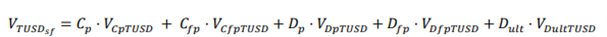

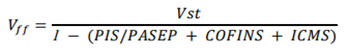

In [ ]:
!git clone https://github.com/byronacunia/UFCA_estudo_mercado_livre.git

Cloning into 'UFCA_estudo_mercado_livre'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 117 (delta 56), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (117/117), 2.72 MiB | 4.78 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [ ]:
abas_de_excel =  pd.ExcelFile("/content/UFCA_estudo_mercado_livre/Raw Data/UFCA.xlsx")
abas_de_excel.sheet_names

['Apresentação', 'UC1', 'UC2', 'UC3', 'UC4']

In [ ]:
UC1 = abas_de_excel.parse("UC1")
UC2 = abas_de_excel.parse("UC2")
UC3 = abas_de_excel.parse("UC3")
UC4 = abas_de_excel.parse("UC4")

In [ ]:
def TOTAL_CONTA_CATIVO_UC(dadosDF,Tarifa_total_P , Tarifa_total_FP, RetencaoFederal ):
  TUSD_FP=Tarifa_total_FP*0.22  #22% Dado da Concecionaria a ser atualizado
  TUSD_P=Tarifa_total_P*0.74    #74% Dado da Concecionaria a ser atualizado
  TE_FP=Tarifa_total_FP-TUSD_FP
  TE_P= Tarifa_total_P-TUSD_P
  dadosDF['Differença Demanda'] = dadosDF['DEMANDA_REGISTRADA_FP'] - dadosDF['DEMANDA_CONTRATADA_P']
  dadosDF['Valor Demanda'] = (dadosDF['DEMANDA_REGISTRADA_FP'] * dadosDF['TAR_TUSD_KW_FP']) +(dadosDF['Differença Demanda'] *-1* dadosDF['TAR_DEMANDA_FP_SEM ICMS'])
  dadosDF['Valor Consumo P+FP TUSD'] = (TUSD_FP*dadosDF['ENERGIA_FPONTA'])+(TUSD_P*dadosDF['ENERGIA_PONTA'])
  dadosDF['Valor Consumo TE'] = (TE_FP*dadosDF['ENERGIA_FPONTA'])+(TE_P*dadosDF['ENERGIA_PONTA'])
  dadosDF['Valor da conta no cativo'] = (dadosDF['Valor Demanda']+dadosDF['Valor Consumo P+FP TUSD']+dadosDF['Valor Consumo TE'])-((dadosDF['Valor Demanda']+dadosDF['Valor Consumo P+FP TUSD']+dadosDF['Valor Consumo TE'])*RetencaoFederal)
  dadosDF['Valor consumo TUSD_FP']= (TUSD_FP*dadosDF['ENERGIA_FPONTA'])
  dadosDF['Valor consumo TUSD_P']= (TUSD_P*dadosDF['ENERGIA_PONTA'])
  TOTAL_CONTA_CATIVO = dadosDF['Valor da conta no cativo'].sum()
  #dadosDF.head()
  return TOTAL_CONTA_CATIVO, dadosDF

In [ ]:
def Analise_de_Mercado_Livre(ANO, Valor_Energia_MWh, UCs):
  Cativo = 0
  lista_UCs = []
  TUSD_Demanda_50parecela = 0
  TUSD_Consumo_4855parecela = 0
  TUSD_Consumo_9711parecela = 0
  Consumo_Total = 0  
  for UC_E in UCs:
    dadosUC_E = UC_E[UC_E['ANO']==ANO][['DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
    del dadosUC_E['index']
    dadosUC_E = dadosUC_E.fillna(method='ffill')
    TOTAL_CONTA_CATIVO_UC_E, dadosUC_E = TOTAL_CONTA_CATIVO_UC(dadosUC_E,Tarifa_total_P=1.81318, Tarifa_total_FP = 0.40733, RetencaoFederal = 0.0620)
    lista_UCs.append(dadosUC_E)
    Cativo = TOTAL_CONTA_CATIVO_UC_E + Cativo
    TUSD_Demanda_50parecela = (dadosUC_E['Valor Demanda']* 0.5) + TUSD_Demanda_50parecela #TUSD Demanda 50% Parcela
    TUSD_Consumo_4855parecela = (dadosUC_E['Valor consumo TUSD_FP'] - (dadosUC_E['Valor consumo TUSD_FP'] * 0.4855 )) + dadosUC_E['Valor consumo TUSD_P'] + TUSD_Consumo_4855parecela #TUSD consumo 48.55%
    TUSD_Consumo_9711parecela = (dadosUC_E['Valor consumo TUSD_FP'] - (dadosUC_E['Valor consumo TUSD_FP'] * 0.9711 )) + dadosUC_E['Valor consumo TUSD_P'] + TUSD_Consumo_9711parecela #TUSD consumo 97.11%
    Consumo_Total=dadosUC_E['ENERGIA_PONTA']+dadosUC_E['ENERGIA_FPONTA'] + Consumo_Total
  print("Cativo = R$",Cativo, "do ano = ", ANO)
  TUSD_TOTAL_50=TUSD_Demanda_50parecela+TUSD_Consumo_4855parecela
  Conta_ML_50=TUSD_TOTAL_50+((Valor_Energia_MWh/1000)*Consumo_Total)
  Livre50=Conta_ML_50.sum()#TOTAL_Conta_ML_50
  print("Livre 50% = R$",Livre50, "do ano = ", ANO)
  TUSD_TOTAL_100=0+TUSD_Consumo_9711parecela #TUSD demanda 100% parcela = 0
  TUSD_TOTAL_100=0+TUSD_Consumo_9711parecela #TUSD demanda 100% parcela = 0
  Conta_ML_100=TUSD_TOTAL_100+((Valor_Energia_MWh/1000)*Consumo_Total)
  Livre100=Conta_ML_100.sum()#TOTAL_Conta_ML_100
  print("Livre 100% = R$",Livre100, "do ano = ", ANO)
  print("Econômia livre 50% = R$",Cativo-Livre50)
  print("Econômia livre 100% = R$",Cativo-Livre100)
  return Cativo, Livre50, Livre100


#Dados de Entrada UC1

In [ ]:
dadosUC1 = UC1[['MÊS', 'ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC1['index']
dadosUC1    

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,139,81.00,7.44000,NaN,10180,792
1,Outubro,2014,139,123.00,8.51000,NaN,18783,1562
2,Novembro,2014,139,133.00,7.74000,NaN,21323,1748
3,Dezembro,2014,139,133.00,7.36000,NaN,16324,1393
4,Janeiro,2015,139,118.00,7.32000,NaN,17178,1359
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,139,105.00,21.46590,15.54059,26620,2316
65,Fevereiro,2020,139,86.94,22.93628,16.29677,14305,942
66,Março,2020,139,154.56,22.84343,NaN,17622,1345
67,Abril,2020,139,154.98,20.82185,NaN,15948,1451


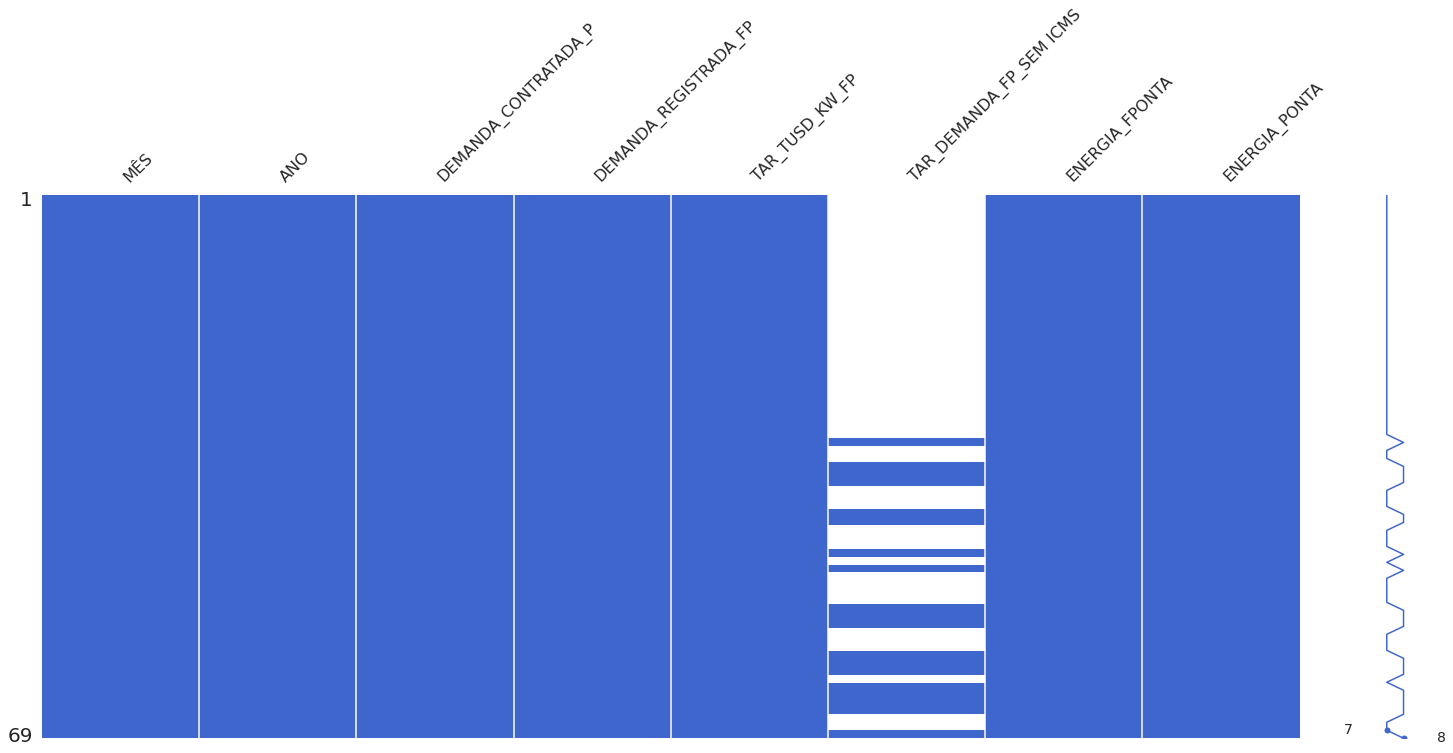

In [ ]:
msno.matrix(dadosUC1, color = (0.25,0.4,0.8))

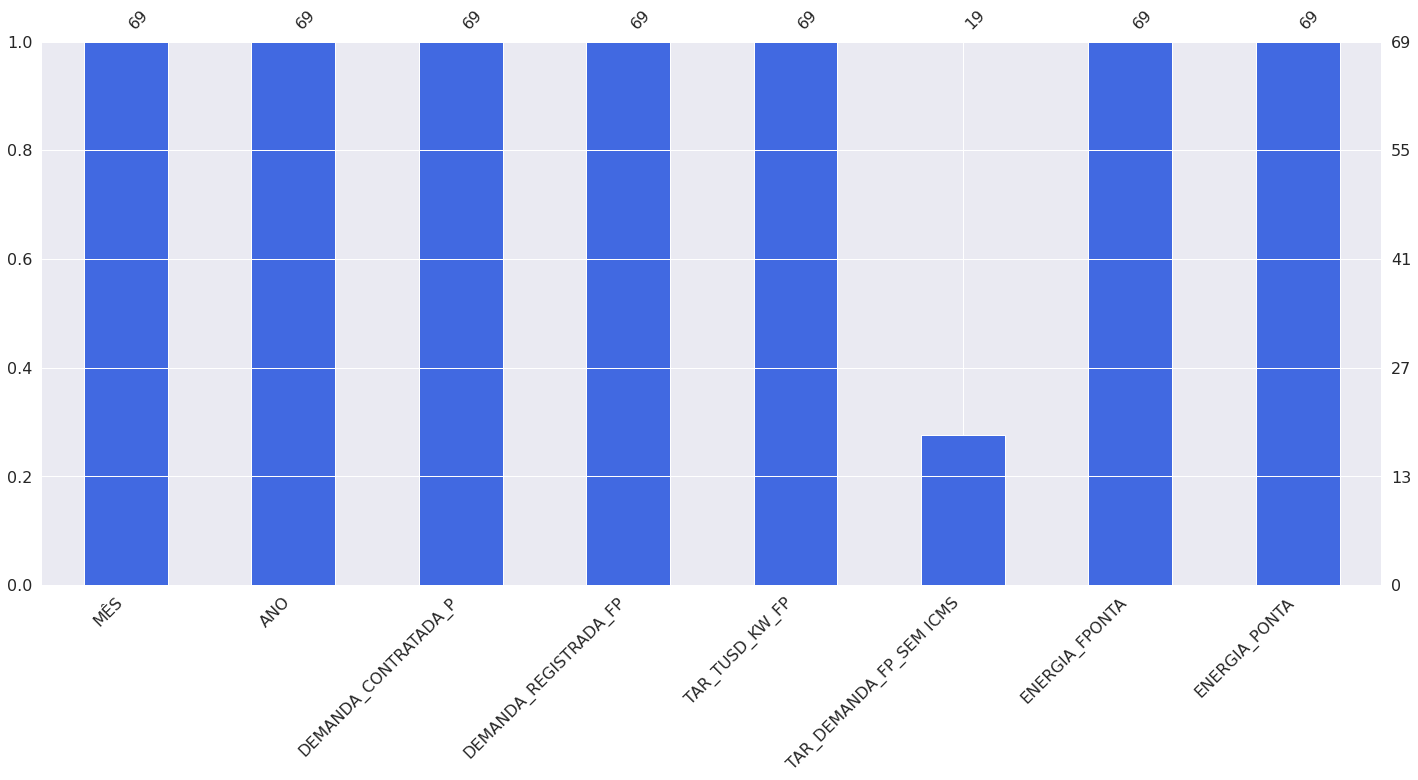

In [ ]:
msno.bar(dadosUC1, color="RoyalBlue")

##Imputação de dados de Entrada da UC1

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC1[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC1['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC1[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

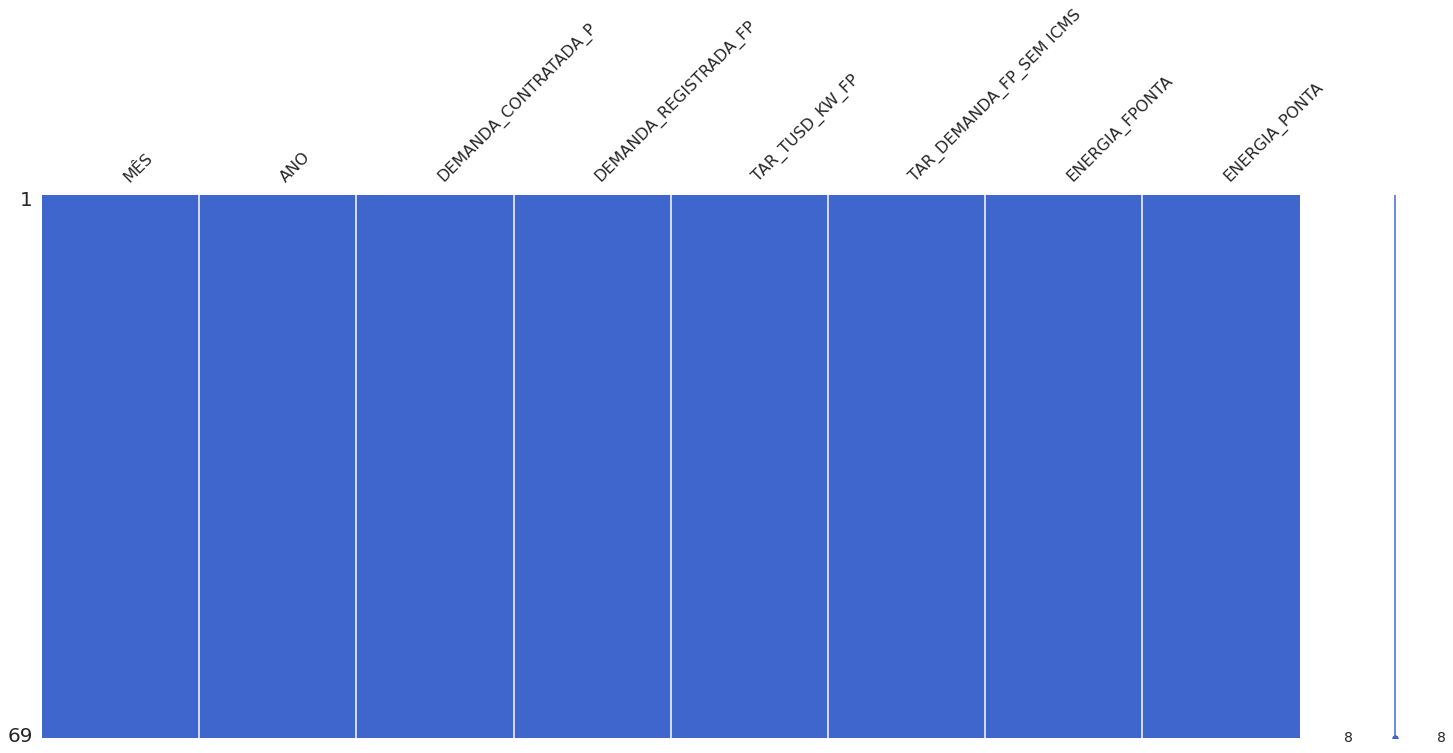

In [ ]:
msno.matrix(dadosUC1, color = (0.25,0.4,0.8))

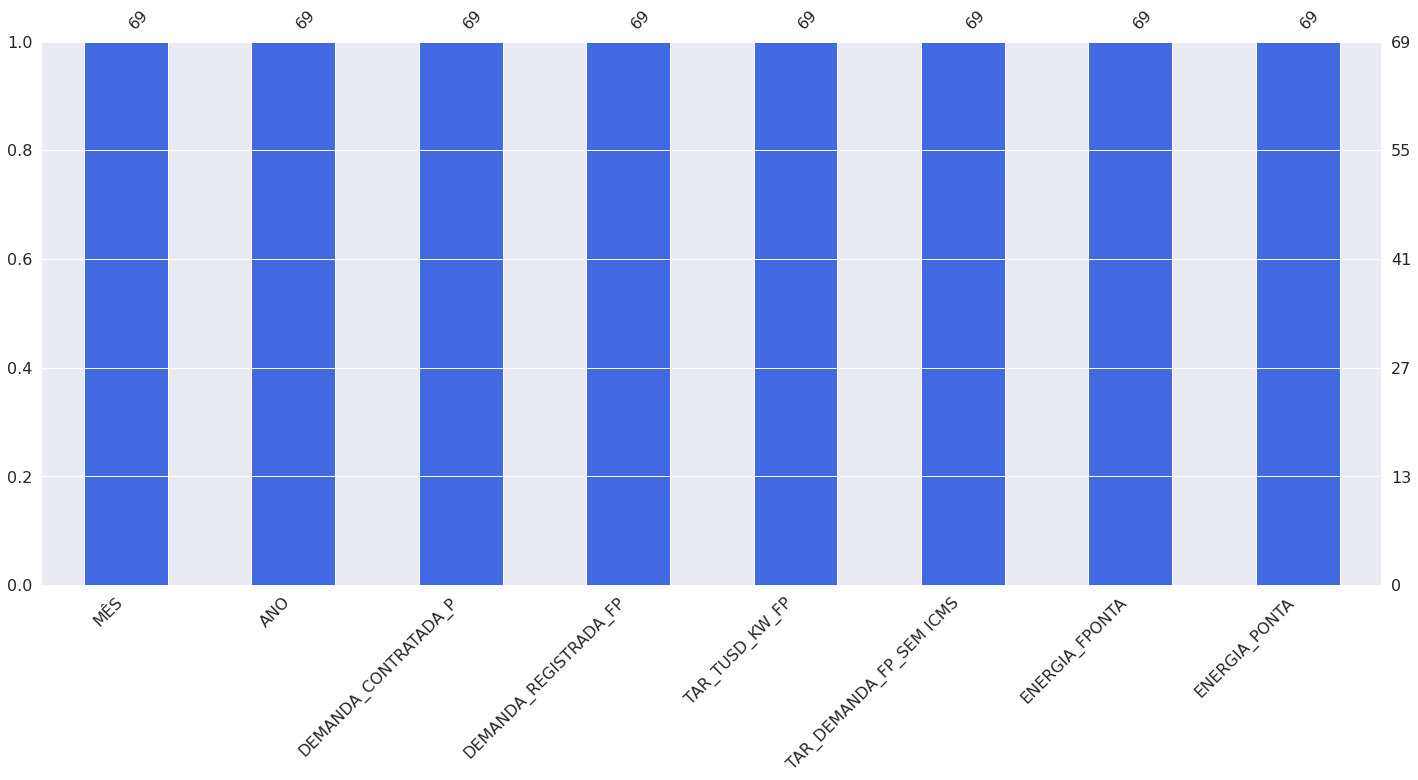

In [ ]:
msno.bar(dadosUC1, color="RoyalBlue")

In [ ]:
dadosUC1

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,139,81.00,7.44000,0.00000,10180,792
1,Outubro,2014,139,123.00,8.51000,0.00000,18783,1562
2,Novembro,2014,139,133.00,7.74000,0.00000,21323,1748
3,Dezembro,2014,139,133.00,7.36000,0.00000,16324,1393
4,Janeiro,2015,139,118.00,7.32000,0.00000,17178,1359
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,139,105.00,21.46590,15.54059,26620,2316
65,Fevereiro,2020,139,86.94,22.93628,16.29677,14305,942
66,Março,2020,139,154.56,22.84343,0.00000,17622,1345
67,Abril,2020,139,154.98,20.82185,0.00000,15948,1451


#Dados de Entrada UC2

In [ ]:
dadosUC2 = UC2[['MÊS','ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC2['index']
dadosUC2

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,63.0,54.00,NaN,NaN,6999.0,569.0
1,Outubro,2014,63.0,70.00,NaN,NaN,12448.0,751.0
2,Novembro,2014,63.0,70.00,7.74000,NaN,13327.0,857.0
3,Dezembro,2014,63.0,70.00,7.36000,NaN,9740.0,627.0
4,Janeiro,2015,63.0,53.00,7.32000,NaN,6978.0,468.0
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,160.0,85.00,21.46588,15.54040,24811.0,1753.0
65,Fevereiro,2020,160.0,66.36,22.93641,16.29667,14403.0,1302.0
66,Março,2020,160.0,91.14,22.84321,16.24964,14740.0,1171.0
67,Abril,2020,160.0,77.70,20.82188,15.20000,9406.0,955.0


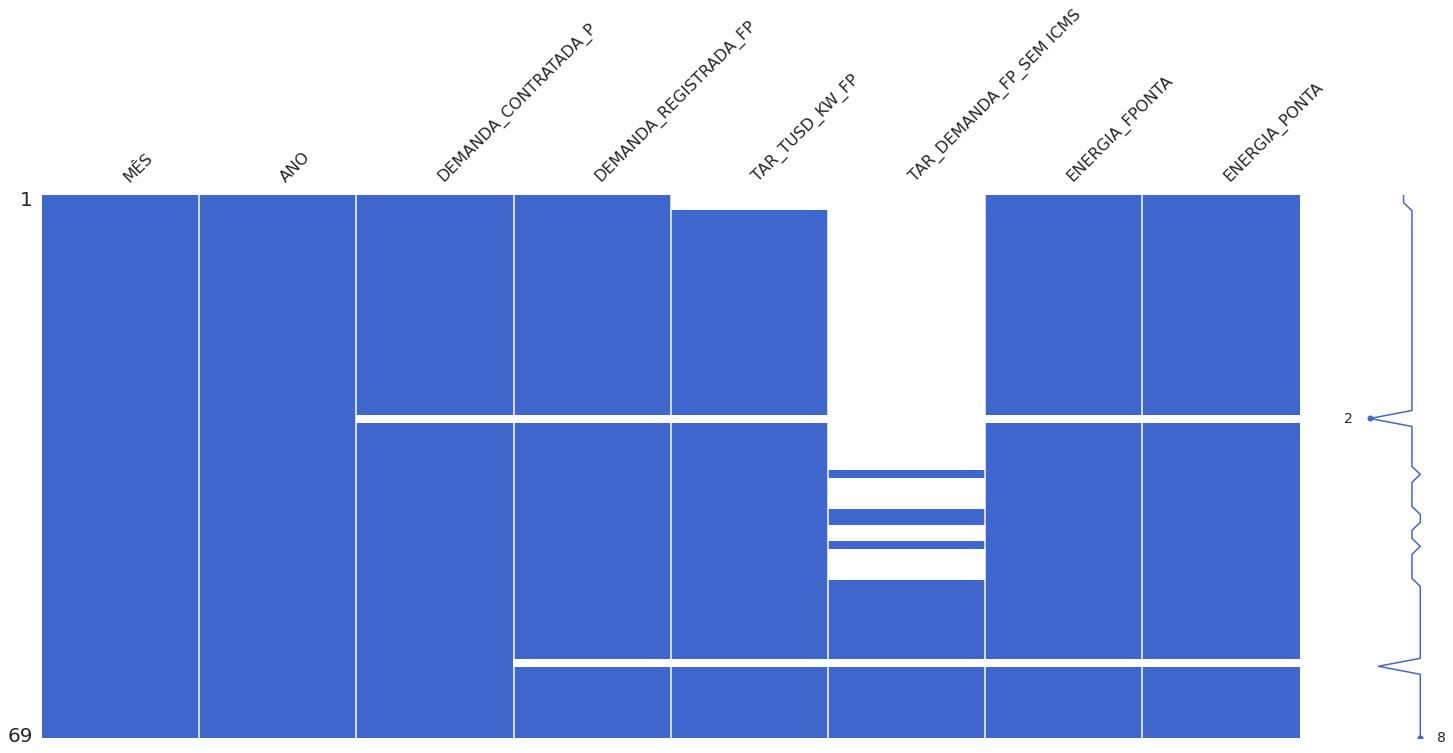

In [ ]:
msno.matrix(dadosUC2, color = (0.25,0.4,0.8))

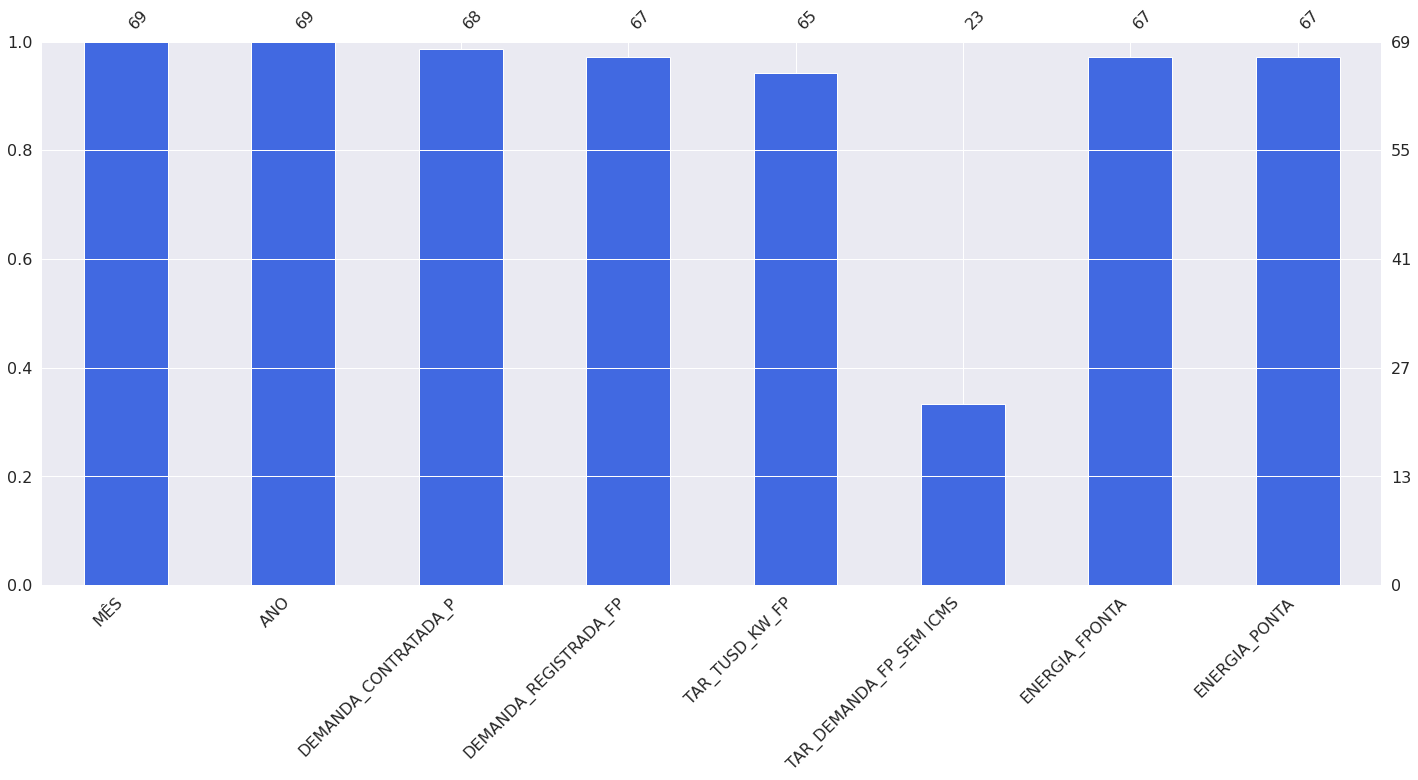

In [ ]:
msno.bar(dadosUC2, color="RoyalBlue")

##Imputação de dados de Entrada da UC2

In [ ]:
#Imputação da "TAR_DEMANDA_FP_SEM ICMS"
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC2[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC2['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC2[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

#Imputação da "DEMANDA_CONTRATADA_P"
dadosUC2['DEMANDA_CONTRATADA_P'] = dadosUC2['DEMANDA_CONTRATADA_P'].fillna(method='ffill')

#Imputação da "TAR_TUSD_KW_FP"
dadosUC2['TAR_TUSD_KW_FP'] = dadosUC2['TAR_TUSD_KW_FP'].fillna(method='bfill')

#Imputação da "DEMANDA_REGISTRADA_FP"
dadosUC2['DEMANDA_REGISTRADA_FP'] = dadosUC2['DEMANDA_REGISTRADA_FP'].fillna(method='ffill')

#Imputação da "ENERGIA_FPONTA"
dadosUC2['ENERGIA_FPONTA'] = dadosUC2['ENERGIA_FPONTA'].fillna(method='ffill')

#Imputação da "ENERGIA_PONTA"
dadosUC2['ENERGIA_PONTA'] = dadosUC2['ENERGIA_PONTA'].fillna(method='ffill')


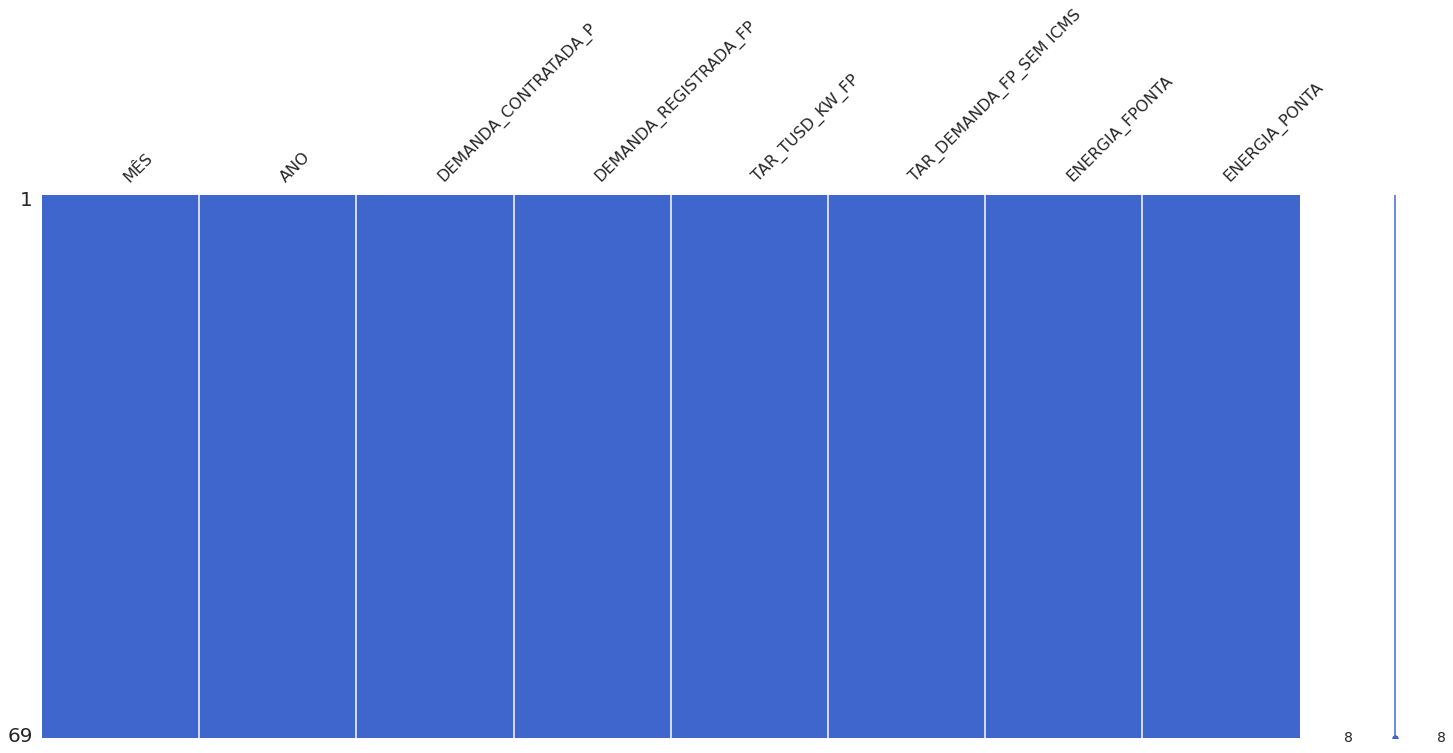

In [ ]:
msno.matrix(dadosUC2, color = (0.25,0.4,0.8))

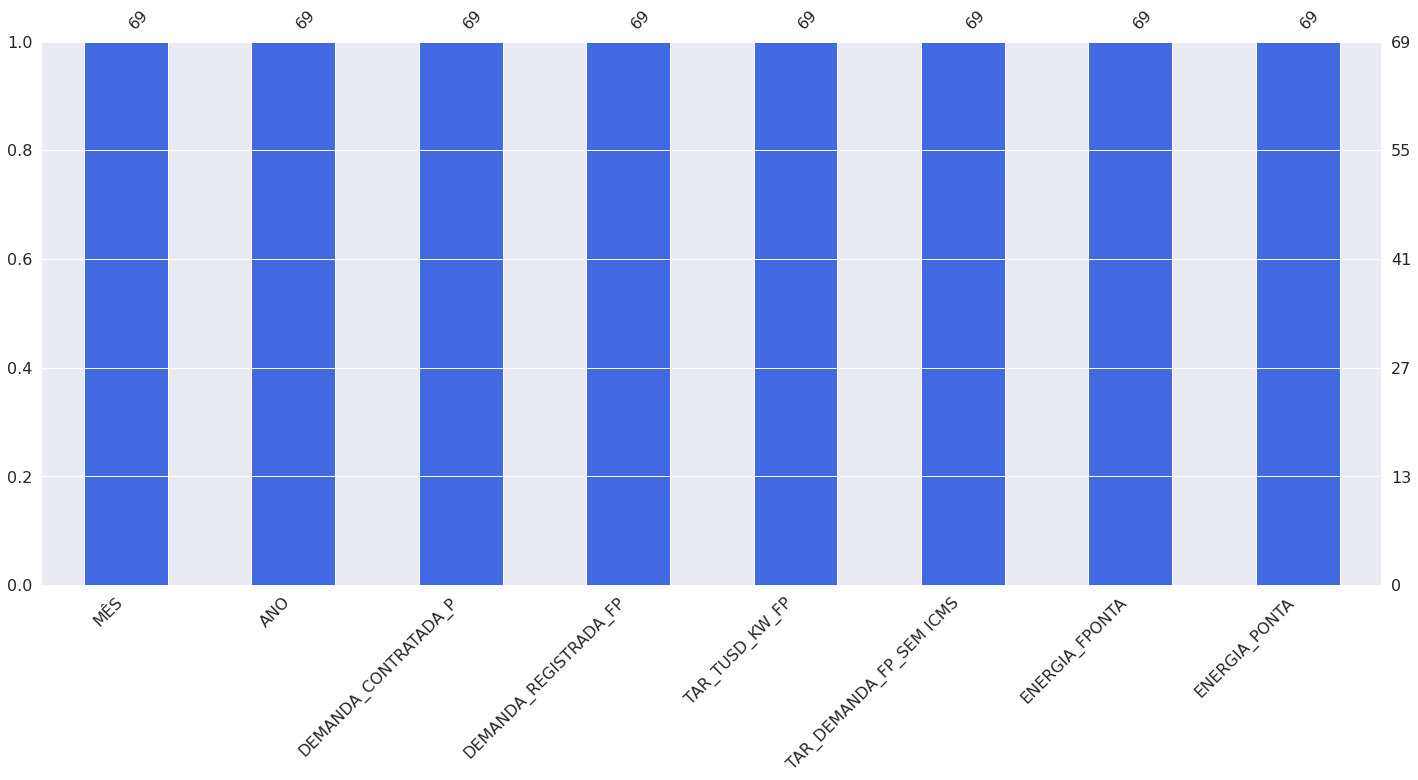

In [ ]:
msno.bar(dadosUC2, color="RoyalBlue")


In [ ]:
dadosUC2

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Julho,2014,63.0,54.00,7.74000,0.00000,6999.0,569.0
1,Outubro,2014,63.0,70.00,7.74000,0.00000,12448.0,751.0
2,Novembro,2014,63.0,70.00,7.74000,0.00000,13327.0,857.0
3,Dezembro,2014,63.0,70.00,7.36000,0.00000,9740.0,627.0
4,Janeiro,2015,63.0,53.00,7.32000,0.00000,6978.0,468.0
...,...,...,...,...,...,...,...,...
64,Janeiro,2020,160.0,85.00,21.46588,15.54040,24811.0,1753.0
65,Fevereiro,2020,160.0,66.36,22.93641,16.29667,14403.0,1302.0
66,Março,2020,160.0,91.14,22.84321,16.24964,14740.0,1171.0
67,Abril,2020,160.0,77.70,20.82188,15.20000,9406.0,955.0


#Dados de Entrada UC3

In [ ]:
dadosUC3 = UC3[['MÊS', 'ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC3['index']
dadosUC3   

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Outubro,2014,257,294.00,8.51000,NaN,55737,9178
1,Novembro,2014,257,302.00,7.74000,NaN,63123,9721
2,Dezembro,2014,257,302.00,7.36000,NaN,43760,7072
3,Janeiro,2015,257,143.00,7.32000,NaN,26793,1039
4,Fevereiro,2015,257,181.00,7.57000,NaN,33321,2520
...,...,...,...,...,...,...,...,...
63,Janeiro,2020,600,489.00,21.46589,15.54027,117522,13778
64,Fevereiro,2020,600,330.96,22.93646,16.29676,72404,6224
65,Março,2020,600,470.40,22.84341,16.24977,81416,8723
66,Abril,2020,600,498.96,20.82191,15.20002,53588,6836


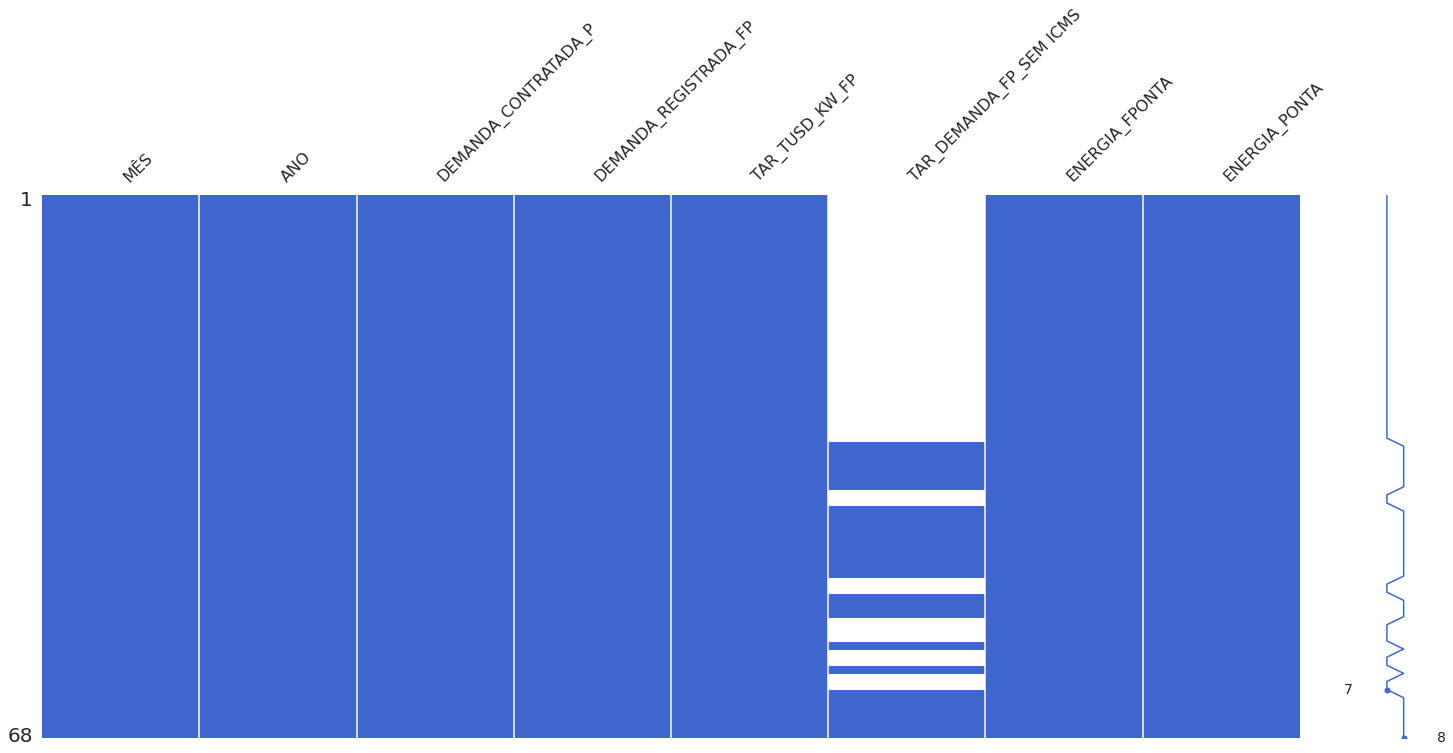

In [ ]:
msno.matrix(dadosUC3, color = (0.25,0.4,0.8))

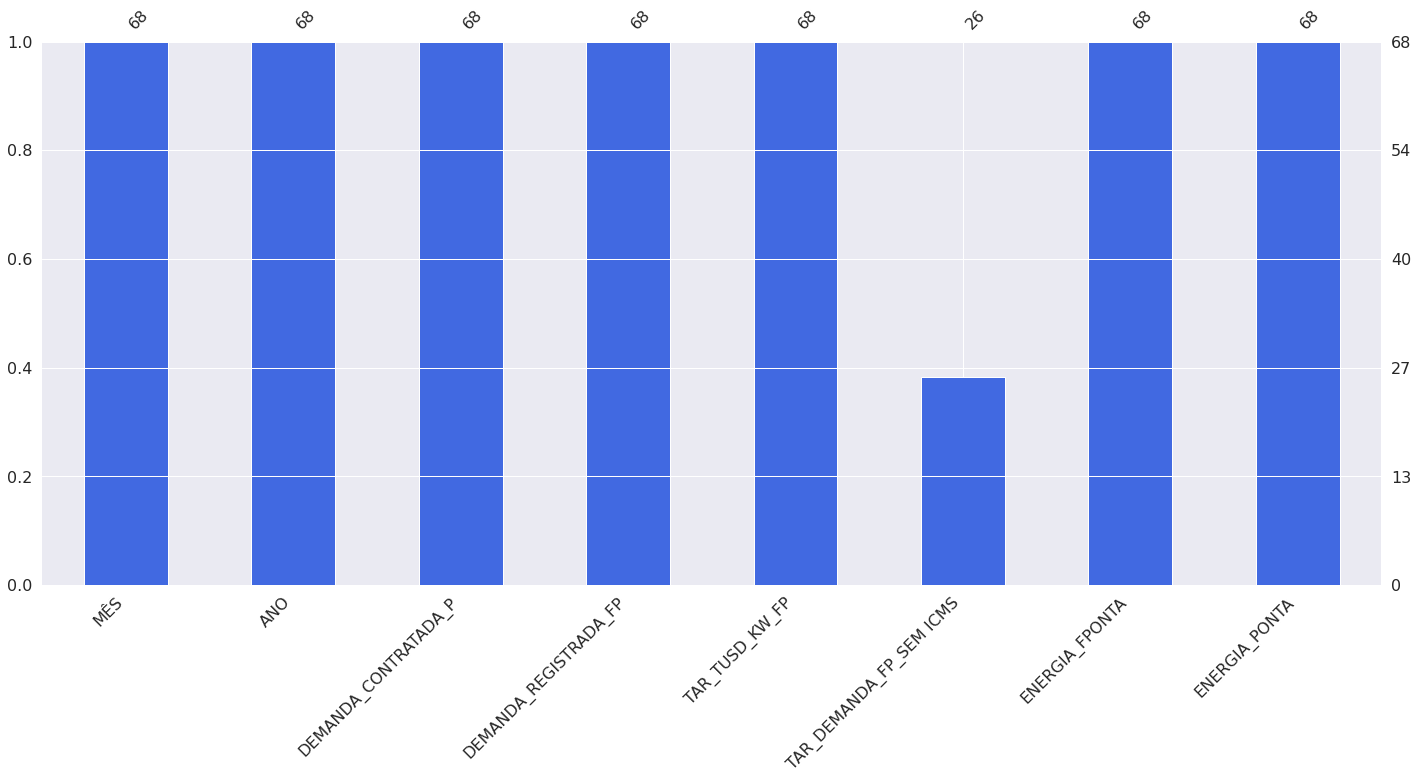

In [ ]:
msno.bar(dadosUC3, color="RoyalBlue")

##Imputação de dados de Entrada da UC3

In [ ]:
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC3[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC3['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC3[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

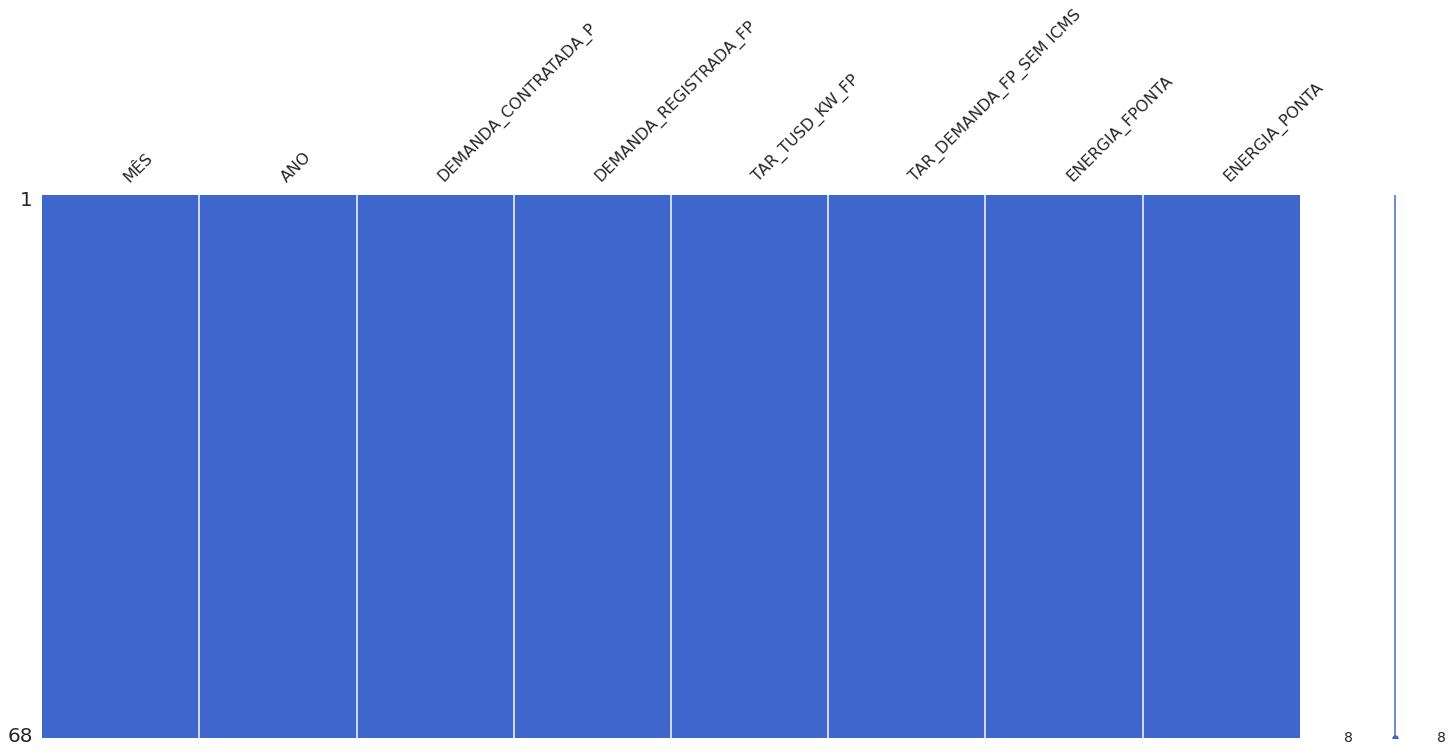

In [ ]:
msno.matrix(dadosUC3, color = (0.25,0.4,0.8))

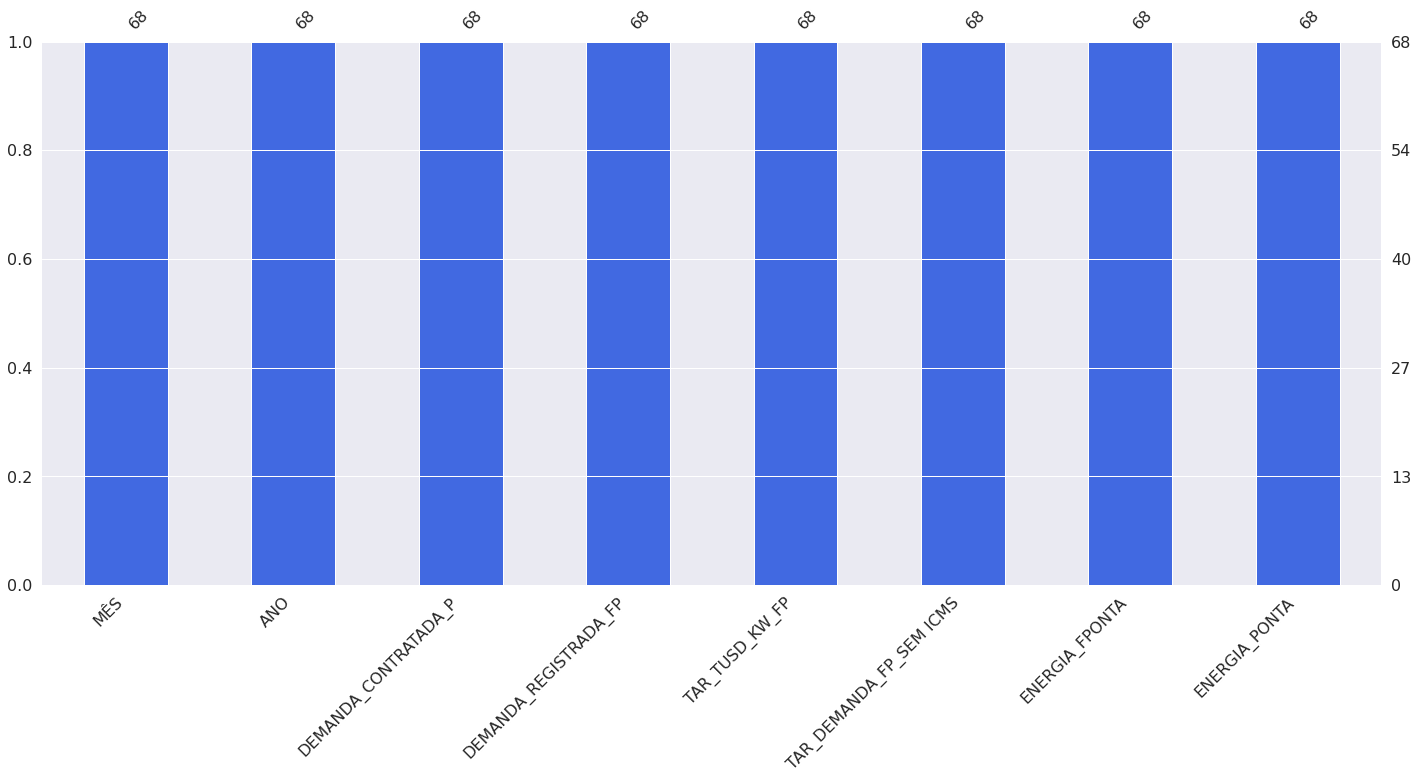

In [ ]:
msno.bar(dadosUC3, color="RoyalBlue")

In [ ]:
dadosUC3

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Outubro,2014,257,294.00,8.51000,0.00000,55737,9178
1,Novembro,2014,257,302.00,7.74000,0.00000,63123,9721
2,Dezembro,2014,257,302.00,7.36000,0.00000,43760,7072
3,Janeiro,2015,257,143.00,7.32000,0.00000,26793,1039
4,Fevereiro,2015,257,181.00,7.57000,0.00000,33321,2520
...,...,...,...,...,...,...,...,...
63,Janeiro,2020,600,489.00,21.46589,15.54027,117522,13778
64,Fevereiro,2020,600,330.96,22.93646,16.29676,72404,6224
65,Março,2020,600,470.40,22.84341,16.24977,81416,8723
66,Abril,2020,600,498.96,20.82191,15.20002,53588,6836


#Dados de Entrada UC4

In [ ]:
dadosUC4 = UC4[['MÊS', 'ANO','DEMANDA_CONTRATADA_P','DEMANDA_REGISTRADA_FP','TAR_TUSD_KW_FP', 'TAR_DEMANDA_FP_SEM ICMS', 'ENERGIA_FPONTA', 'ENERGIA_PONTA']].reset_index()
del dadosUC4['index']
dadosUC4   

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Janeiro,2017,60,4.00,10.47000,NaN,NaN,NaN
1,Fevereiro,2017,60,4.00,10.47000,NaN,405.0,NaN
2,Março,2017,60,3.00,10.52000,NaN,1001.0,NaN
3,Abril,2017,83,4.00,10.48000,NaN,979.0,NaN
4,Maio,2017,30,6.00,17.56000,NaN,810.0,NaN
5,Junho,2017,30,4.00,18.14000,NaN,908.0,102.0
6,Julho,2017,30,3.00,17.45000,NaN,842.0,118.0
7,Agosto,2017,30,4.00,17.30000,NaN,860.0,136.0
8,Setembro,2017,30,4.00,17.86000,12.73269,955.0,141.0
9,Outubro,2017,30,5.00,17.60000,12.60000,1098.0,153.0


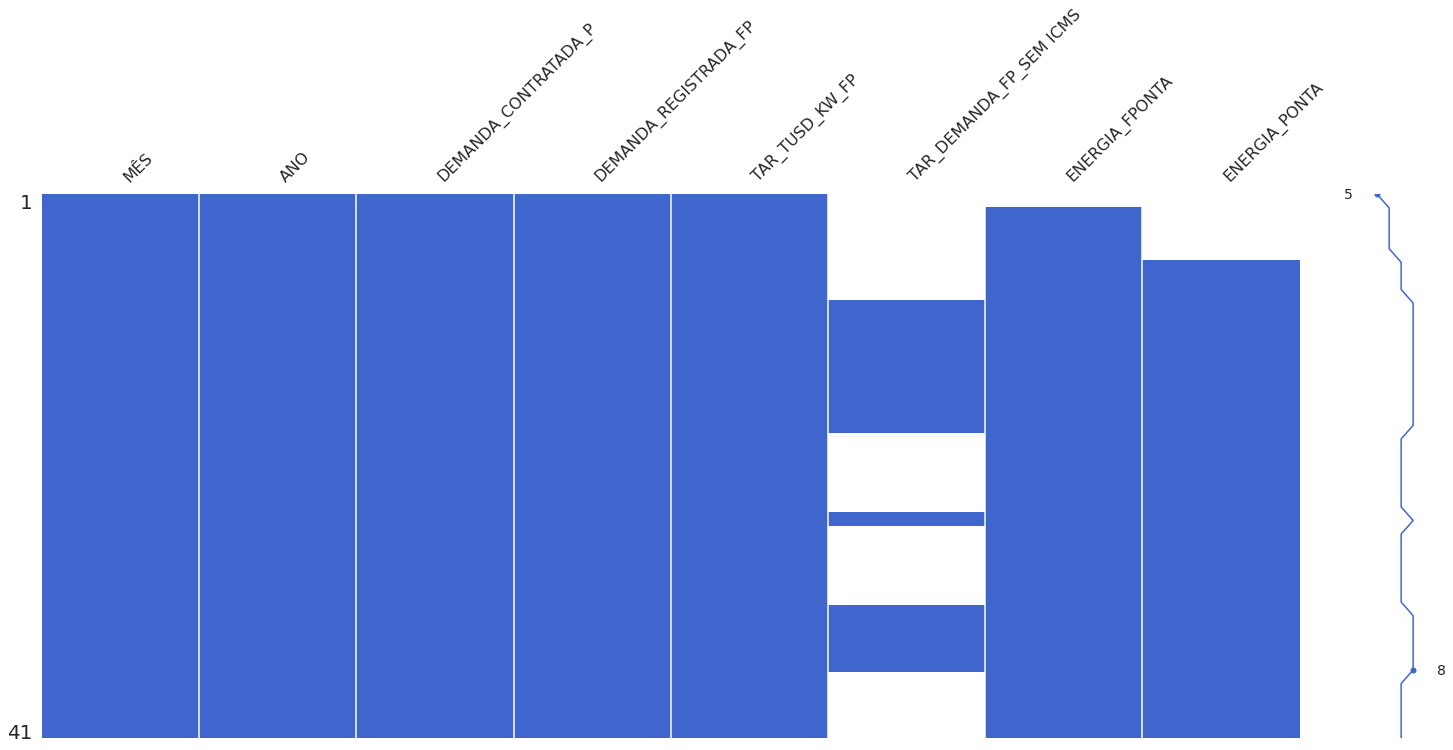

In [ ]:
msno.matrix(dadosUC4, color = (0.25,0.4,0.8))

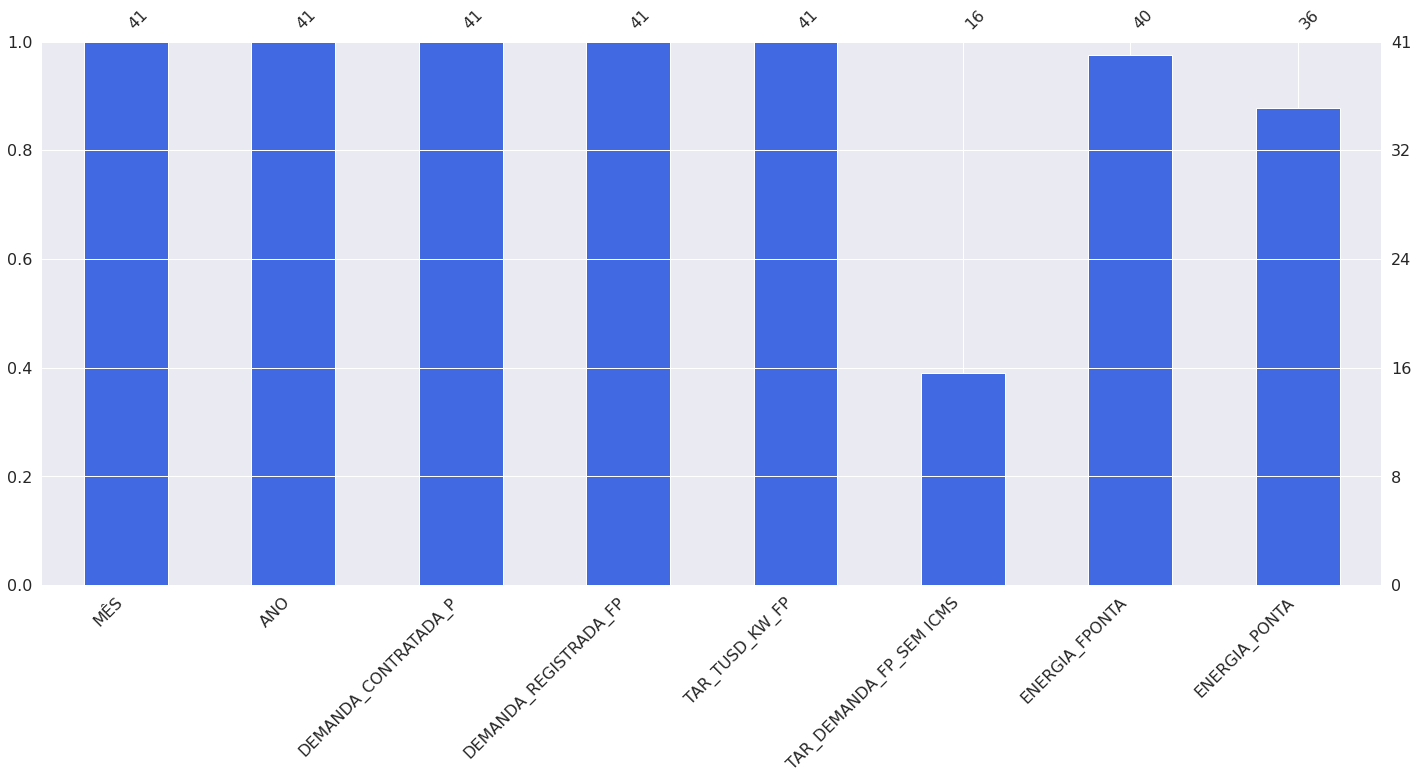

In [ ]:
msno.bar(dadosUC4, color="RoyalBlue")

##Imputação de dados de Entrada da UC4

In [ ]:
#Imputação da "TAR_DEMANDA_FP_SEM ICMS"
imputer = SimpleImputer(strategy='constant', fill_value = 0)
imputer = imputer.fit(dadosUC4[['TAR_DEMANDA_FP_SEM ICMS']])
dadosUC4['TAR_DEMANDA_FP_SEM ICMS'] = imputer.transform(dadosUC4[['TAR_DEMANDA_FP_SEM ICMS']]).ravel()

#Imputação da "ENERGIA_FPONTA"
dadosUC4['ENERGIA_FPONTA'] = dadosUC4['ENERGIA_FPONTA'].fillna(method='bfill')

#Imputação da "ENERGIA_PONTA"
dadosUC4['ENERGIA_PONTA'] = dadosUC4['ENERGIA_PONTA'].fillna(method='bfill')

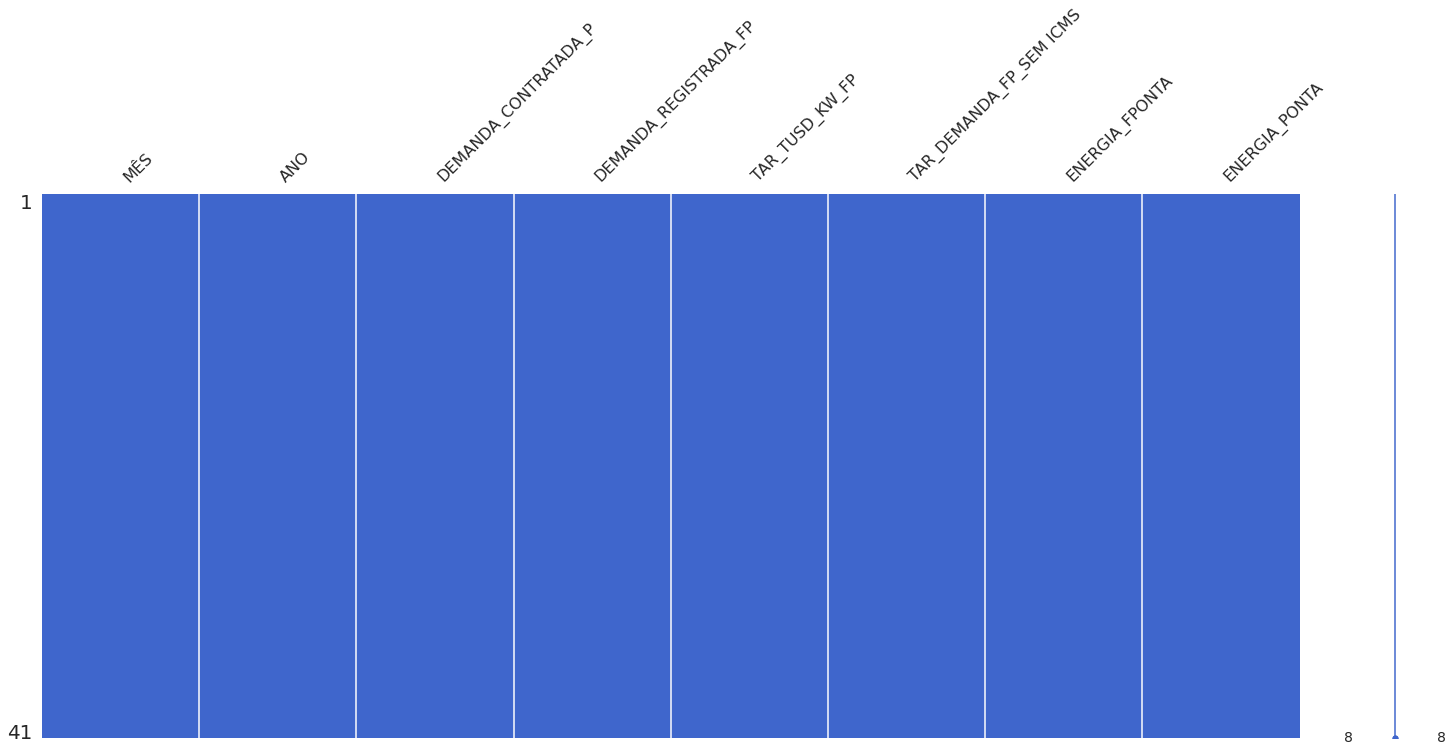

In [ ]:
msno.matrix(dadosUC4, color = (0.25,0.4,0.8))

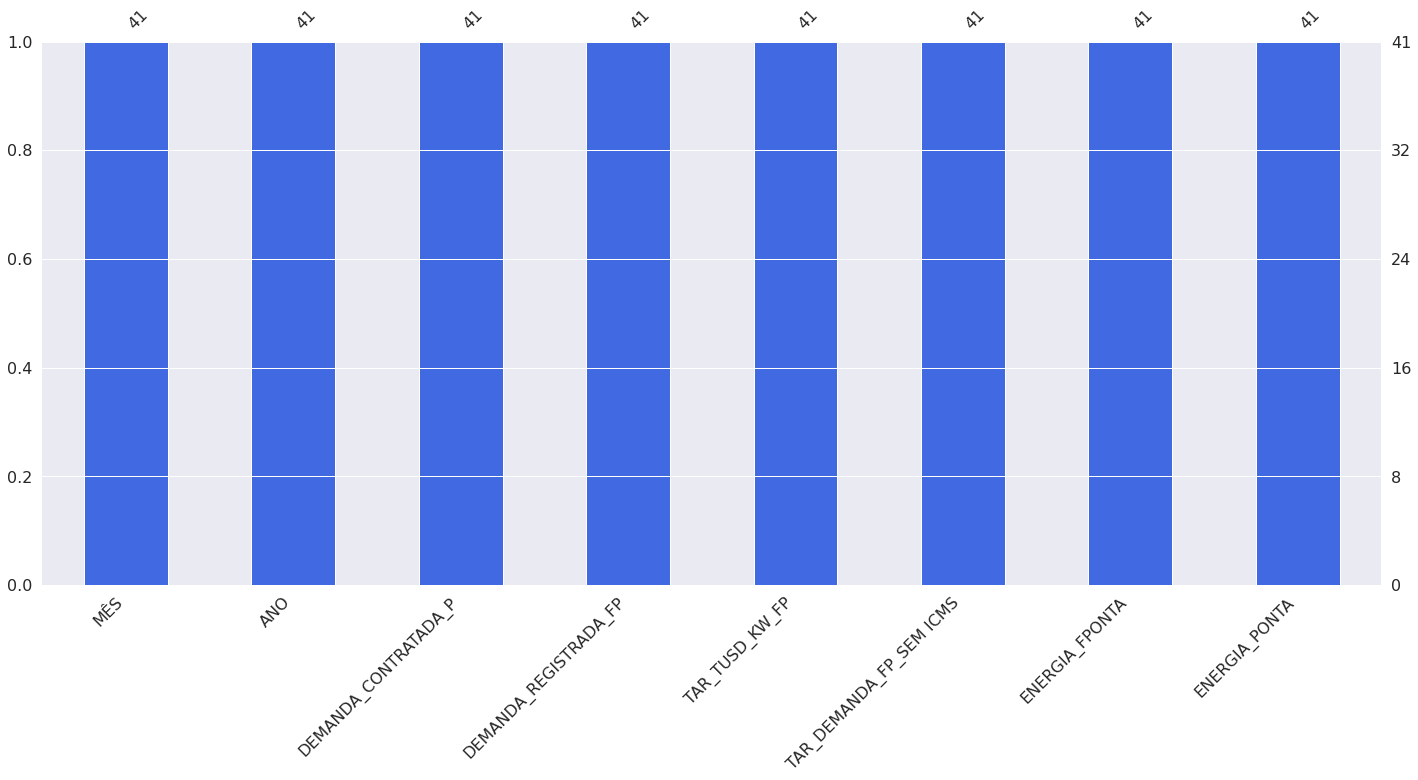

In [ ]:
msno.bar(dadosUC4, color="RoyalBlue")

In [ ]:
dadosUC4

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
0,Janeiro,2017,60,4.00,10.47000,0.00000,405.0,102.0
1,Fevereiro,2017,60,4.00,10.47000,0.00000,405.0,102.0
2,Março,2017,60,3.00,10.52000,0.00000,1001.0,102.0
3,Abril,2017,83,4.00,10.48000,0.00000,979.0,102.0
4,Maio,2017,30,6.00,17.56000,0.00000,810.0,102.0
5,Junho,2017,30,4.00,18.14000,0.00000,908.0,102.0
6,Julho,2017,30,3.00,17.45000,0.00000,842.0,118.0
7,Agosto,2017,30,4.00,17.30000,0.00000,860.0,136.0
8,Setembro,2017,30,4.00,17.86000,12.73269,955.0,141.0
9,Outubro,2017,30,5.00,17.60000,12.60000,1098.0,153.0


#Figuras dos Dados Originais UC1

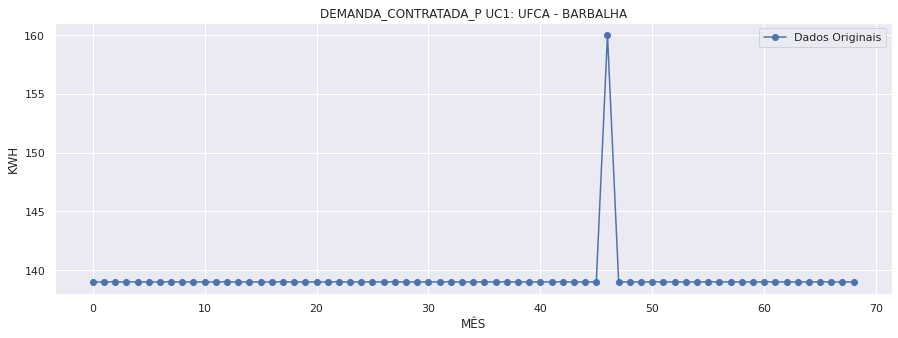

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC1['DEMANDA_CONTRATADA_P'])), dadosUC1['DEMANDA_CONTRATADA_P'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_CONTRATADA_P UC1: UFCA - BARBALHA")
plt.show()

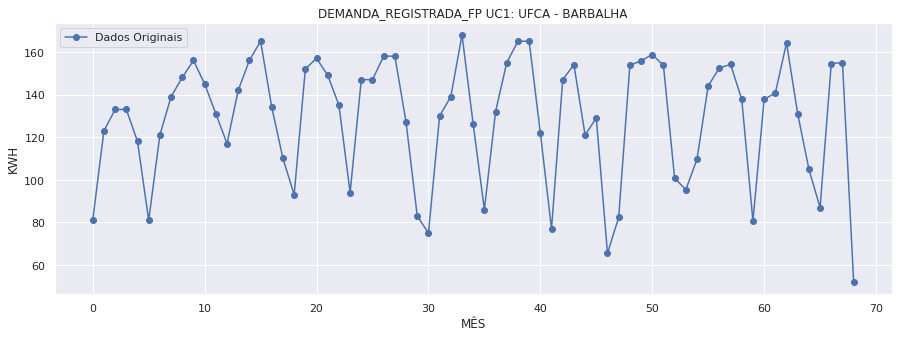

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC1['DEMANDA_REGISTRADA_FP'])), dadosUC1['DEMANDA_REGISTRADA_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_REGISTRADA_FP UC1: UFCA - BARBALHA")
plt.show()

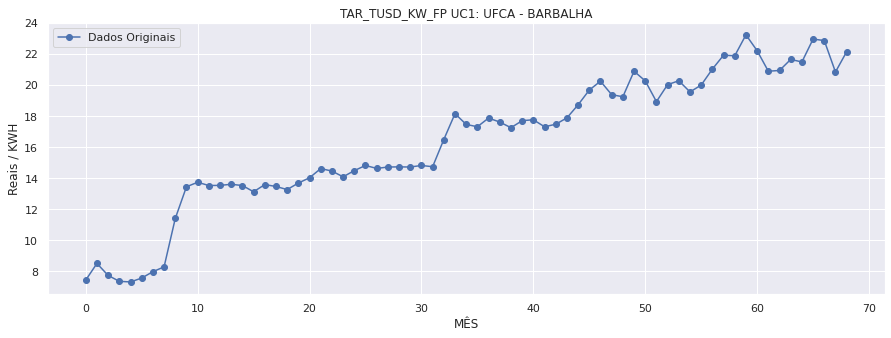

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC1['TAR_TUSD_KW_FP'])), dadosUC1['TAR_TUSD_KW_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_TUSD_KW_FP UC1: UFCA - BARBALHA")
plt.show()

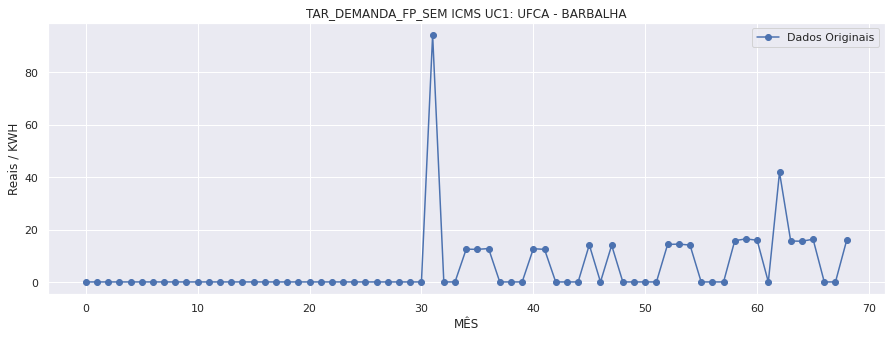

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC1['TAR_DEMANDA_FP_SEM ICMS'])), dadosUC1['TAR_DEMANDA_FP_SEM ICMS'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_DEMANDA_FP_SEM ICMS UC1: UFCA - BARBALHA")
plt.show()

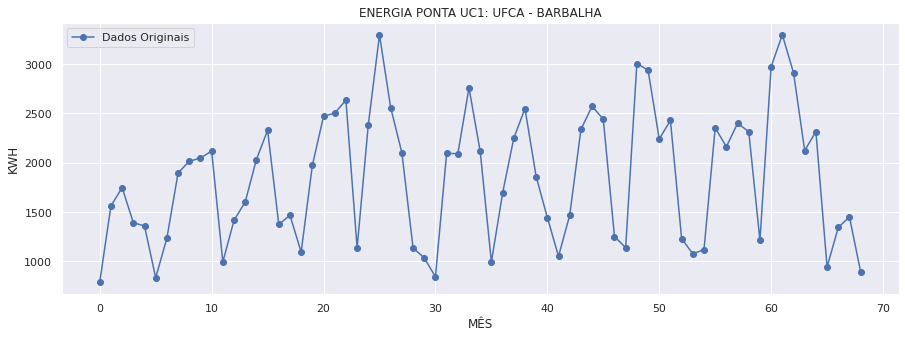

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC1['ENERGIA_PONTA'])), dadosUC1['ENERGIA_PONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA PONTA UC1: UFCA - BARBALHA")
plt.show()

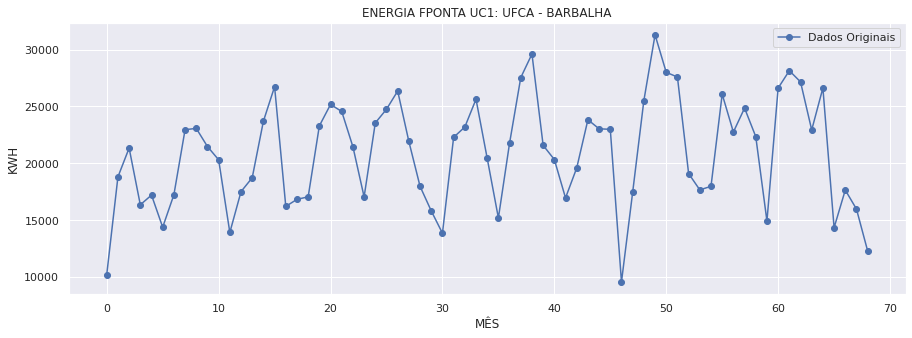

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC1['ENERGIA_FPONTA'])), dadosUC1['ENERGIA_FPONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA FPONTA UC1: UFCA - BARBALHA")
plt.show()

#Figuras dos Dados Originais UC2

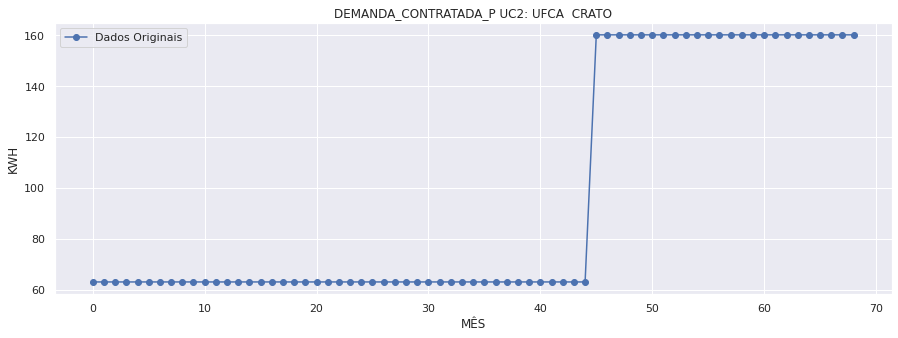

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC2['DEMANDA_CONTRATADA_P'])), dadosUC2['DEMANDA_CONTRATADA_P'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_CONTRATADA_P UC2: UFCA  CRATO")
plt.show()

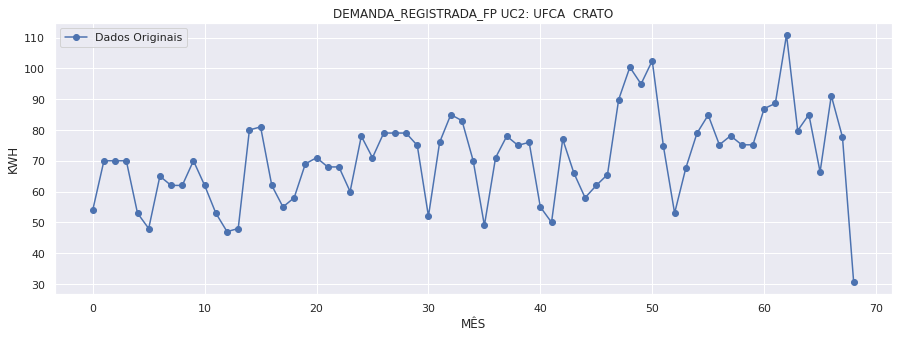

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC2['DEMANDA_REGISTRADA_FP'])), dadosUC2['DEMANDA_REGISTRADA_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_REGISTRADA_FP UC2: UFCA  CRATO")
plt.show()

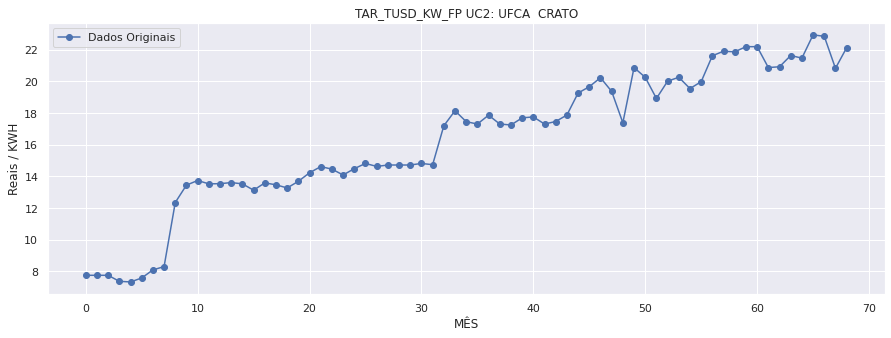

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC2['TAR_TUSD_KW_FP'])), dadosUC2['TAR_TUSD_KW_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_TUSD_KW_FP UC2: UFCA  CRATO")
plt.show()

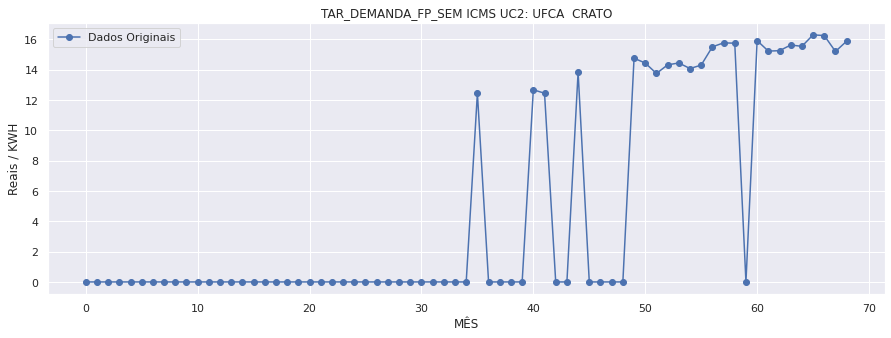

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC2['TAR_DEMANDA_FP_SEM ICMS'])), dadosUC2['TAR_DEMANDA_FP_SEM ICMS'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_DEMANDA_FP_SEM ICMS UC2: UFCA  CRATO")
plt.show()

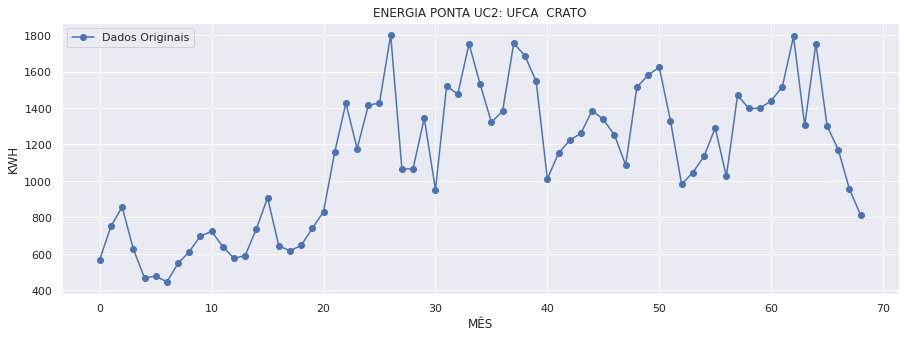

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC2['ENERGIA_PONTA'])), dadosUC2['ENERGIA_PONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA PONTA UC2: UFCA  CRATO")
plt.show()

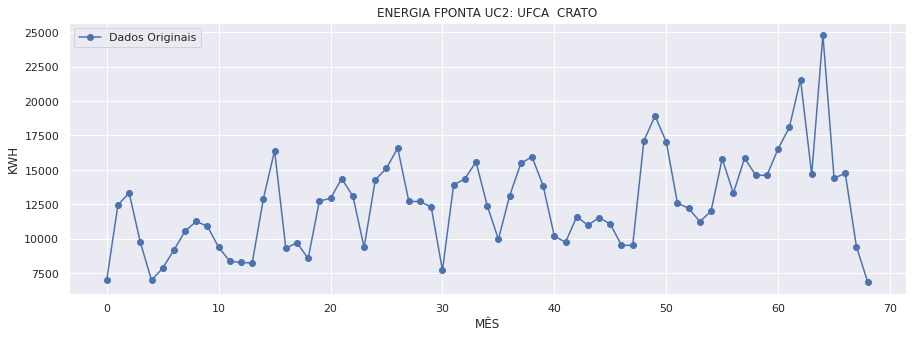

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC2['ENERGIA_FPONTA'])), dadosUC2['ENERGIA_FPONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA FPONTA UC2: UFCA  CRATO")
plt.show()

#Figuras dos Dados Originais UC3

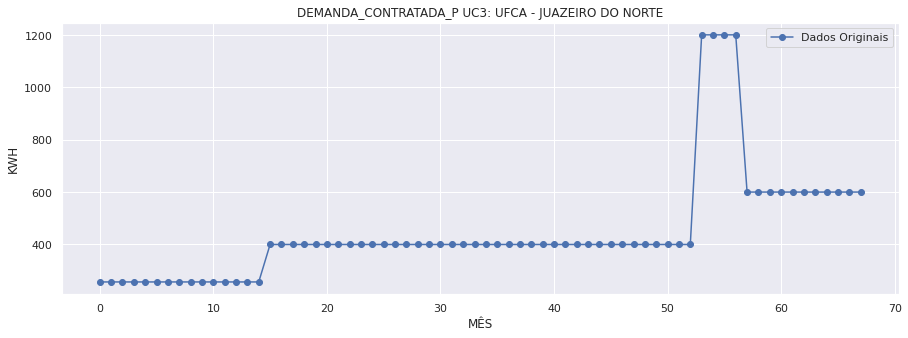

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC3['DEMANDA_CONTRATADA_P'])), dadosUC3['DEMANDA_CONTRATADA_P'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_CONTRATADA_P UC3: UFCA - JUAZEIRO DO NORTE")
plt.show()

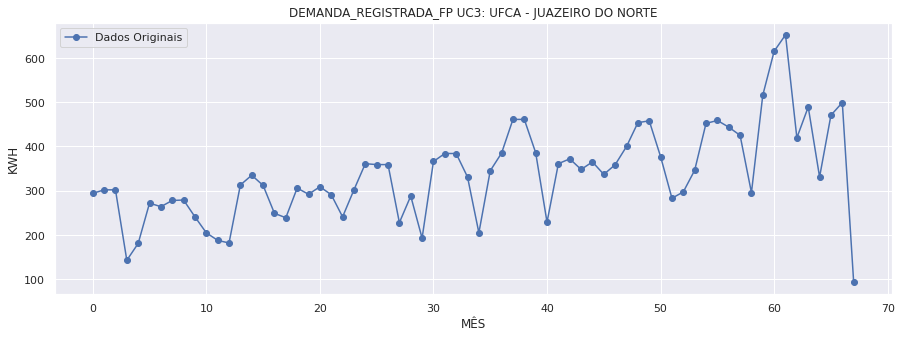

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC3['DEMANDA_REGISTRADA_FP'])), dadosUC3['DEMANDA_REGISTRADA_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_REGISTRADA_FP UC3: UFCA - JUAZEIRO DO NORTE")
plt.show()

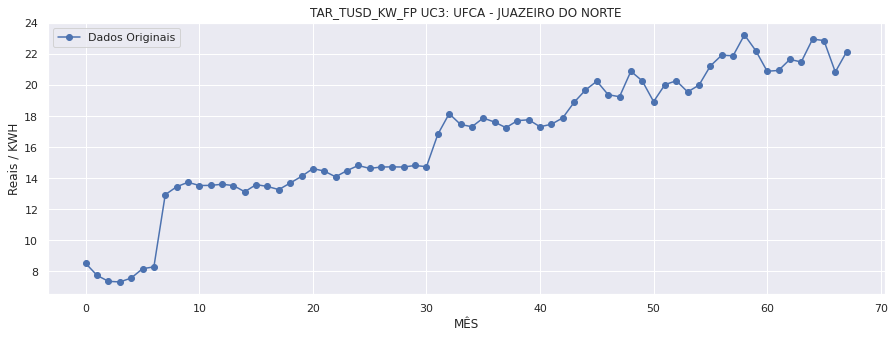

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC3['TAR_TUSD_KW_FP'])), dadosUC3['TAR_TUSD_KW_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_TUSD_KW_FP UC3: UFCA - JUAZEIRO DO NORTE")
plt.show()

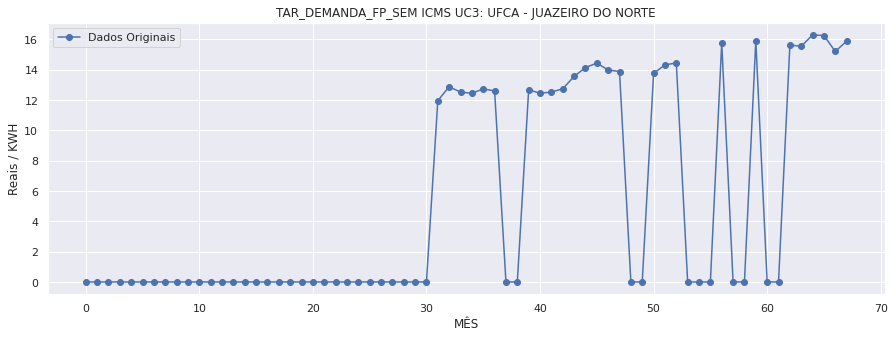

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC3['TAR_DEMANDA_FP_SEM ICMS'])), dadosUC3['TAR_DEMANDA_FP_SEM ICMS'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_DEMANDA_FP_SEM ICMS UC3: UFCA - JUAZEIRO DO NORTE")
plt.show()

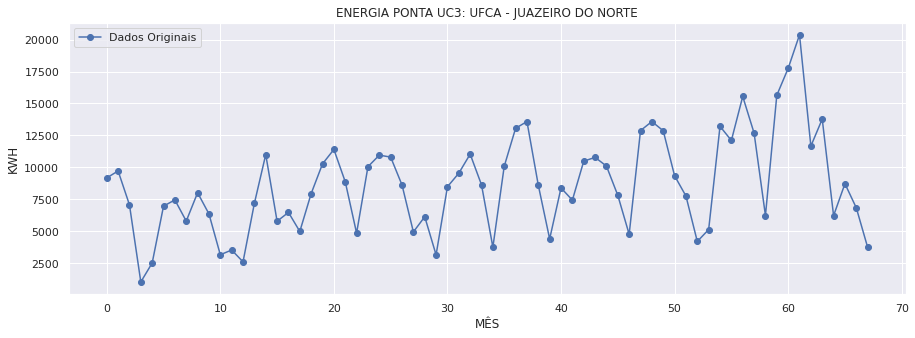

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC3['ENERGIA_PONTA'])), dadosUC3['ENERGIA_PONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA PONTA UC3: UFCA - JUAZEIRO DO NORTE")
plt.show()

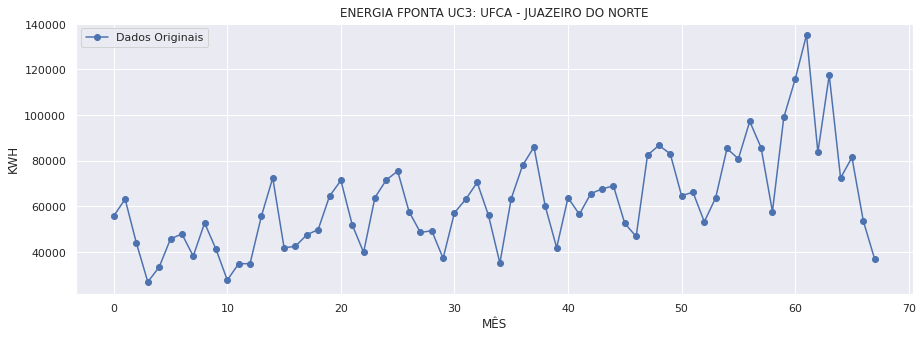

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC3['ENERGIA_FPONTA'])), dadosUC3['ENERGIA_FPONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA FPONTA UC3: UFCA - JUAZEIRO DO NORTE")
plt.show()

#Figuras dos Dados Originais UC4

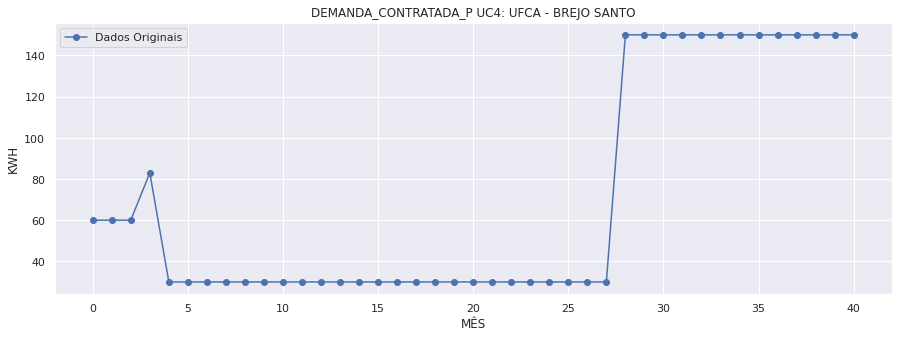

In [ ]:
 fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC4['DEMANDA_CONTRATADA_P'])), dadosUC4['DEMANDA_CONTRATADA_P'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_CONTRATADA_P UC4: UFCA - BREJO SANTO")
plt.show()

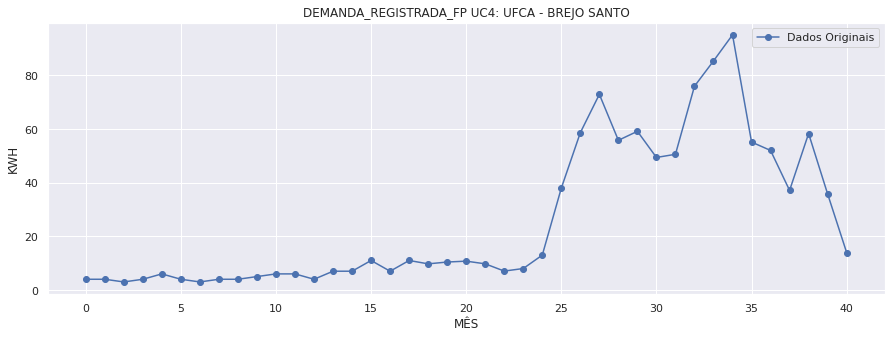

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC4['DEMANDA_REGISTRADA_FP'])), dadosUC4['DEMANDA_REGISTRADA_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("DEMANDA_REGISTRADA_FP UC4: UFCA - BREJO SANTO")
plt.show()

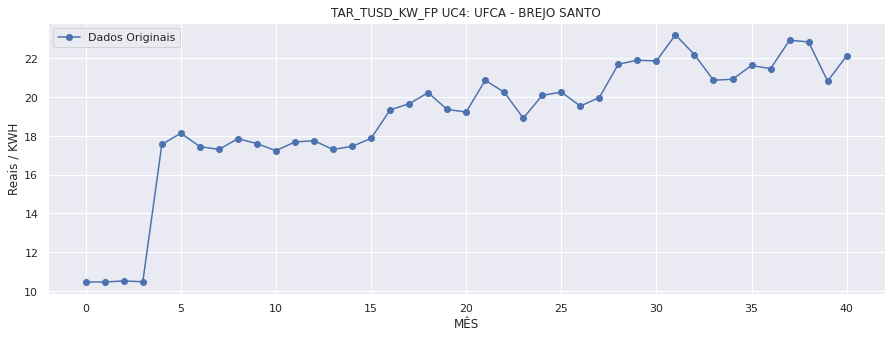

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC4['TAR_TUSD_KW_FP'])), dadosUC4['TAR_TUSD_KW_FP'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_TUSD_KW_FP UC4: UFCA - BREJO SANTO")
plt.show()

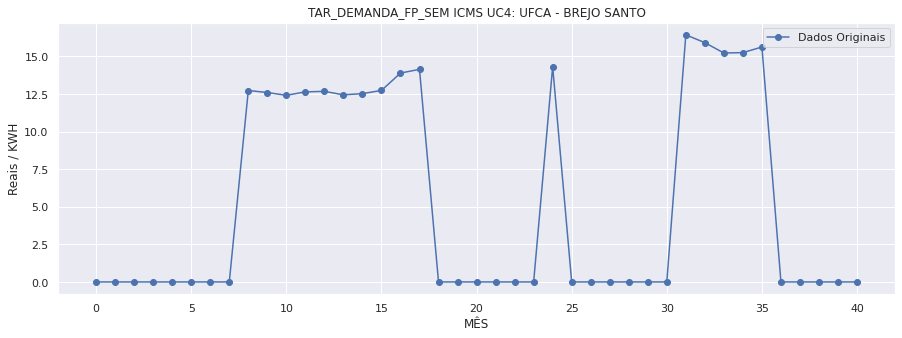

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC4['TAR_DEMANDA_FP_SEM ICMS'])), dadosUC4['TAR_DEMANDA_FP_SEM ICMS'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("Reais / KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("TAR_DEMANDA_FP_SEM ICMS UC4: UFCA - BREJO SANTO")
plt.show()

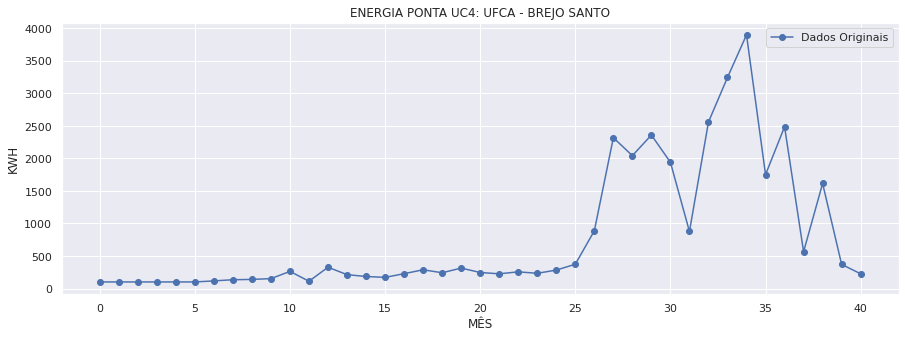

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC4['ENERGIA_PONTA'])), dadosUC4['ENERGIA_PONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA PONTA UC4: UFCA - BREJO SANTO")
plt.show()

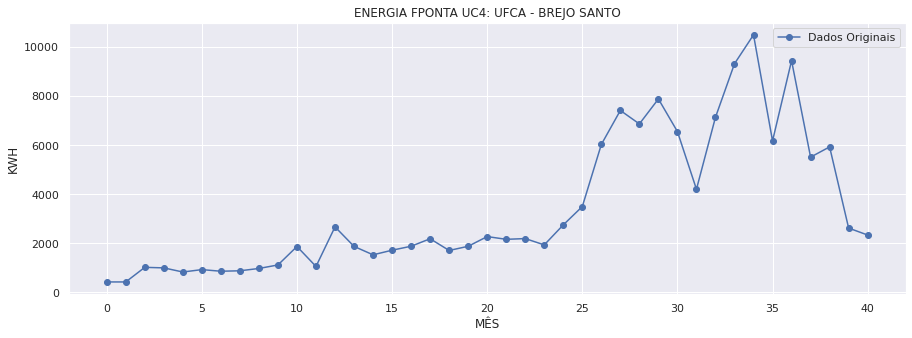

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(dadosUC4['ENERGIA_FPONTA'])), dadosUC4['ENERGIA_FPONTA'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend(['Dados Originais'])
_ = plt.title("ENERGIA FPONTA UC4: UFCA - BREJO SANTO")
plt.show()

#Previsões

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
             break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
def RMSE(yh, y):
  er = yh - y
  RMSE = sum(er*er/len(er))**0.5
  return RMSE

In [ ]:
def modelo_de_previsao(dadosDF, Variavel):
  Lista_de_modelos = []
  Lista_de_RMSE=[]
  meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
  for mes in meses:
    data = dadosDF[dadosDF['MÊS']==mes][[Variavel]]
    df_train = data[Variavel].iloc[:len(data)-1]
    df_test = data[Variavel].iloc[len(data)-1:]
    X_train, Y_train = split_sequence(df_train.values,1)
    Y_test = df_test.values
    X_test = np.array(Y_train[-1])
    modelo = LinearRegression() 
    modelo.fit(X_train, Y_train)
    Lista_de_modelos.append(modelo)
    previsoes = modelo.predict(X_test.reshape((1,1)))
    print("RMSE da Previsão de",Variavel,"do",mes,"=", RMSE(previsoes, Y_test))
    valorRMSE = RMSE(previsoes, Y_test)
    Lista_de_RMSE.append(valorRMSE)
  return Lista_de_modelos, Lista_de_RMSE

In [ ]:
class Modelos_de_Previsao_UC:
  def __init__(self, nome, dados):
    self.nome = nome
    self.dados = dados.copy(deep= True)

  def DEMANDA_REGISTRADA_FP(self, modelos_DEMANDA_REGISTRADA_FP, RMSE_DEMANDA_REGISTRADA_FP):
    self.modelos_DEMANDA_REGISTRADA_FP = modelos_DEMANDA_REGISTRADA_FP
    self.RMSE_DEMANDA_REGISTRADA_FP = RMSE_DEMANDA_REGISTRADA_FP 
  
  def TAR_TUSD_KW_FP(self, modelos_TAR_TUSD_KW_FP, RMSE_TAR_TUSD_KW_FP):
    self.modelos_TAR_TUSD_KW_FP = modelos_TAR_TUSD_KW_FP
    self.RMSE_TAR_TUSD_KW_FP = RMSE_TAR_TUSD_KW_FP 
  
  def TAR_DEMANDA_FP_SEM_ICMS(self, modelos_TAR_DEMANDA_FP_SEM_ICMS, RMSE_TAR_DEMANDA_FP_SEM_ICMS ):
    self.modelos_TAR_DEMANDA_FP_SEM_ICMS = modelos_TAR_DEMANDA_FP_SEM_ICMS
    self.RMSE_TAR_DEMANDA_FP_SEM_ICMS = RMSE_TAR_DEMANDA_FP_SEM_ICMS 

  def ENERGIA_PONTA(self, modelos_ENERGIA_PONTA, RMSE_ENERGIA_PONTA):
    self.modelos_ENERGIA_PONTA = modelos_ENERGIA_PONTA
    self.RMSE_ENERGIA_PONTA = RMSE_ENERGIA_PONTA
  
  def ENERGIA_FPONTA(self, modelos_ENERGIA_FPONTA, RMSE_ENERGIA_FPONTA):
    self.modelos_ENERGIA_FPONTA = modelos_ENERGIA_FPONTA
    self.RMSE_ENERGIA_FPONTA = RMSE_ENERGIA_FPONTA  

In [ ]:
dados_list = [dadosUC1, dadosUC2, dadosUC3, dadosUC4]
modelosUCs=[]
i = 1
for dado in dados_list:
  print('Inicio dos Resultados da UC'+str(i))
  locals()['UC'+str(i)] = Modelos_de_Previsao_UC(nome= 'UC'+str(i), dados= dado)
  modelo, valorRMSE = modelo_de_previsao(dadosDF= dado, Variavel="DEMANDA_REGISTRADA_FP")
  locals()['UC'+str(i)].DEMANDA_REGISTRADA_FP(modelos_DEMANDA_REGISTRADA_FP= modelo, RMSE_DEMANDA_REGISTRADA_FP= valorRMSE)
  modelo, valorRMSE = modelo_de_previsao(dadosDF= dado, Variavel="TAR_TUSD_KW_FP")
  locals()['UC'+str(i)].TAR_TUSD_KW_FP(modelos_TAR_TUSD_KW_FP= modelo, RMSE_TAR_TUSD_KW_FP= valorRMSE)
  modelo, valorRMSE = modelo_de_previsao(dadosDF= dado, Variavel="TAR_DEMANDA_FP_SEM ICMS")
  locals()['UC'+str(i)].TAR_DEMANDA_FP_SEM_ICMS(modelos_TAR_DEMANDA_FP_SEM_ICMS= modelo, RMSE_TAR_DEMANDA_FP_SEM_ICMS= valorRMSE)
  modelo, valorRMSE = modelo_de_previsao(dadosDF= dado, Variavel="ENERGIA_PONTA")
  locals()['UC'+str(i)].ENERGIA_PONTA(modelos_ENERGIA_PONTA= modelo, RMSE_ENERGIA_PONTA= valorRMSE)
  modelo, valorRMSE = modelo_de_previsao(dadosDF= dado, Variavel="ENERGIA_FPONTA")
  locals()['UC'+str(i)].ENERGIA_FPONTA(modelos_ENERGIA_FPONTA= modelo, RMSE_ENERGIA_FPONTA= valorRMSE)
  modelosUCs.append(locals()['UC'+str(i)])
  print('Fin dos Resultados da UC'+str(i))
  i+=1

Inicio dos Resultados da UC1
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Janeiro = 11.556707530647984
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Fevereiro = 1.1923275138121738
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Março = 48.59439759999999
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Abril = 10.198968421052655
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Maio = 59.920000000000016
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Junho = 52.170469314079355
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Julho = 0.5780648501931012
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Agosto = 1.54642359745516
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Setembro = 4.379999999999967
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Outubro = 15.66201766561511
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Novembro = 3.941710726643578
RMSE da Previsão de DEMANDA_REGISTRADA_FP do Dezembro = 29.893636809815945
RMSE da Previsão de TAR_TUSD_KW_FP do Janeiro = 0.9793158427210393
RMSE da Previsão de TAR_TUSD_

In [ ]:
modelosUCs[3].dados.tail()

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
36,Janeiro,2020,150,52.00,21.46596,0.0,9433.0,2486.0
37,Fevereiro,2020,150,37.12,22.93588,0.0,5497.0,567.0
38,Março,2020,150,58.30,22.84338,0.0,5915.0,1615.0
39,Abril,2020,150,35.78,20.82189,0.0,2603.0,372.0
40,Maio,2020,150,13.95,22.12616,0.0,2319.0,227.0


In [ ]:
numero_mes = {
  'Janeiro': 0,
  'Fevereiro': 1,
  'Março': 2, 
  'Abril': 3, 
  'Maio': 4, 
  'Junho': 5, 
  'Julho': 6, 
  'Agosto': 7, 
  'Setembro': 8, 
  'Outubro': 9, 
  'Novembro': 10, 
  'Dezembro': 11
}

In [ ]:
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
for modelo in modelosUCs:
  #Loop de Previsões
  while True:
    mesAtual = modelo.dados.iloc[-1][0]
    AnoAtual = modelo.dados.iloc[-1][1]
    DEMANDA_CONTRATADA_PAtual = modelo.dados.iloc[-1][2]
    DEMANDA_REGISTRADA_FPAtual = modelo.dados.iloc[-1][3]
    TAR_TUSD_KW_FPAtual = modelo.dados.iloc[-1][4]
    TAR_DEMANDA_FP_SEM_ICMSAtual = modelo.dados.iloc[-1][5]
    ENERGIA_FPONTAAtual = modelo.dados.iloc[-1][6]
    ENERGIA_PONTAAtual = modelo.dados.iloc[-1][7]
    index = numero_mes[mesAtual]
    if mesAtual == 'Dezembro' and AnoAtual == 2021:
      break
    if index< 11:
      mesPrevisto = meses[index+1]                              ##Elemento da nova linha
      AnoPrevisto = AnoAtual                                    ##Elemento da nova linha
      DEMANDA_CONTRATADA_PPrevisto = DEMANDA_CONTRATADA_PAtual  ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['DEMANDA_REGISTRADA_FP']]
      previsao = modelo.modelos_DEMANDA_REGISTRADA_FP[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      DEMANDA_REGISTRADA_FPPrevisto = previsao[0]               ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['TAR_TUSD_KW_FP']]
      previsao = modelo.modelos_TAR_TUSD_KW_FP[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      TAR_TUSD_KW_FPPrevisto = previsao[0]                      ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['TAR_DEMANDA_FP_SEM ICMS']]
      previsao = modelo.modelos_TAR_DEMANDA_FP_SEM_ICMS[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      TAR_DEMANDA_FP_SEM_ICMSPrevisto = previsao[0]              ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['ENERGIA_FPONTA']]
      previsao = modelo.modelos_ENERGIA_FPONTA[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      ENERGIA_FPONTAPrevisto = previsao[0]              ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['ENERGIA_PONTA']]
      previsao = modelo.modelos_ENERGIA_PONTA[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      ENERGIA_PONTAPrevisto = previsao[0]              ##Elemento da nova linha
      row = [mesPrevisto, AnoPrevisto, DEMANDA_CONTRATADA_PPrevisto, DEMANDA_REGISTRADA_FPPrevisto,TAR_TUSD_KW_FPPrevisto,TAR_DEMANDA_FP_SEM_ICMSPrevisto,ENERGIA_FPONTAPrevisto,ENERGIA_PONTAPrevisto]
      modelo.dados.loc[len(modelo.dados)] = row
      print("Previsão do Mês = ", mesPrevisto,"do Ano=", AnoPrevisto, "da", modelo.nome)
    if index == 11:
      index = -1
      mesPrevisto = meses[index+1]                              ##Elemento da nova linha
      AnoPrevisto = AnoAtual+1                                    ##Elemento da nova linha
      DEMANDA_CONTRATADA_PPrevisto = DEMANDA_CONTRATADA_PAtual  ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['DEMANDA_REGISTRADA_FP']]
      previsao = modelo.modelos_DEMANDA_REGISTRADA_FP[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      DEMANDA_REGISTRADA_FPPrevisto = previsao[0]               ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['TAR_TUSD_KW_FP']]
      previsao = modelo.modelos_TAR_TUSD_KW_FP[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      TAR_TUSD_KW_FPPrevisto = previsao[0]                      ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['TAR_DEMANDA_FP_SEM ICMS']]
      previsao = modelo.modelos_TAR_DEMANDA_FP_SEM_ICMS[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      TAR_DEMANDA_FP_SEM_ICMSPrevisto = previsao[0]              ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['ENERGIA_FPONTA']]
      previsao = modelo.modelos_ENERGIA_FPONTA[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      ENERGIA_FPONTAPrevisto = previsao[0]              ##Elemento da nova linha
      data = modelo.dados[modelo.dados['MÊS']==mesPrevisto][['ENERGIA_PONTA']]
      previsao = modelo.modelos_ENERGIA_PONTA[index+1].predict(data.iloc[-1][0].reshape((1,1)))
      ENERGIA_PONTAPrevisto = previsao[0]              ##Elemento da nova linha
      row = [mesPrevisto, AnoPrevisto, DEMANDA_CONTRATADA_PPrevisto, DEMANDA_REGISTRADA_FPPrevisto,TAR_TUSD_KW_FPPrevisto,TAR_DEMANDA_FP_SEM_ICMSPrevisto,ENERGIA_FPONTAPrevisto,ENERGIA_PONTAPrevisto]
      modelo.dados.loc[len(modelo.dados)] = row 
      print("Previsão do Mês = ", mesPrevisto,"do Ano=", AnoPrevisto, "da", modelo.nome)

Previsão do Mês =  Junho do Ano= 2020 da UC1
Previsão do Mês =  Julho do Ano= 2020 da UC1
Previsão do Mês =  Agosto do Ano= 2020 da UC1
Previsão do Mês =  Setembro do Ano= 2020 da UC1
Previsão do Mês =  Outubro do Ano= 2020 da UC1
Previsão do Mês =  Novembro do Ano= 2020 da UC1
Previsão do Mês =  Dezembro do Ano= 2020 da UC1
Previsão do Mês =  Janeiro do Ano= 2021 da UC1
Previsão do Mês =  Fevereiro do Ano= 2021 da UC1
Previsão do Mês =  Março do Ano= 2021 da UC1
Previsão do Mês =  Abril do Ano= 2021 da UC1
Previsão do Mês =  Maio do Ano= 2021 da UC1
Previsão do Mês =  Junho do Ano= 2021 da UC1
Previsão do Mês =  Julho do Ano= 2021 da UC1
Previsão do Mês =  Agosto do Ano= 2021 da UC1
Previsão do Mês =  Setembro do Ano= 2021 da UC1
Previsão do Mês =  Outubro do Ano= 2021 da UC1
Previsão do Mês =  Novembro do Ano= 2021 da UC1
Previsão do Mês =  Dezembro do Ano= 2021 da UC1
Previsão do Mês =  Junho do Ano= 2020 da UC2
Previsão do Mês =  Julho do Ano= 2020 da UC2
Previsão do Mês =  Agosto 

In [ ]:
modelo.dados.tail()

,MÊS,ANO,DEMANDA_CONTRATADA_P,DEMANDA_REGISTRADA_FP,TAR_TUSD_KW_FP,TAR_DEMANDA_FP_SEM ICMS,ENERGIA_FPONTA,ENERGIA_PONTA
55,Agosto,2021,150,10.42,19.36096,0.0,1860.0,315.0
56,Setembro,2021,150,10.75,19.22977,0.0,2256.0,247.0
57,Outubro,2021,150,9.75,20.86872,0.0,2144.0,227.0
58,Novembro,2021,150,7.05,20.24823,0.0,2174.0,257.0
59,Dezembro,2021,150,8.00,18.91625,0.0,1917.0,235.0


In [ ]:
#row = ['Junho', 2020, 139, 53,23,16,13255,994]
#modelosUCs[0].dados.loc[len(modelosUCs[0].dados)] = row

#Analise de Mercado considerando as previsões

In [ ]:
UCs_input=[modelosUCs[0].dados,modelosUCs[1].dados,modelosUCs[2].dados,modelosUCs[3].dados]
Cativo_2019, Livre50_2019, Livre100_2019 = Analise_de_Mercado_Livre(ANO=2019, Valor_Energia_MWh=240,UCs=UCs_input)

Cativo = R$ 1148097.4362850133 do ano =  2019
Livre 50% = R$ 878931.1360767834 do ano =  2019
Livre 100% = R$ 702140.367115496 do ano =  2019
Econômia livre 50% = R$ 269166.3002082299
Econômia livre 100% = R$ 445957.0691695174


In [ ]:
Cativo_2020, Livre50_2020, Livre100_2020 = Analise_de_Mercado_Livre(ANO=2020, Valor_Energia_MWh=240,UCs=UCs_input)

Cativo = R$ 955733.3926093061 do ano =  2020
Livre 50% = R$ 720520.5013153933 do ano =  2020
Livre 100% = R$ 559767.1711605825 do ano =  2020
Econômia livre 50% = R$ 235212.8912939129
Econômia livre 100% = R$ 395966.2214487237


In [ ]:
Cativo_2021, Livre50_2021, Livre100_2021 = Analise_de_Mercado_Livre(ANO=2021, Valor_Energia_MWh=240,UCs=UCs_input)

Cativo = R$ 1023520.2728907315 do ano =  2021
Livre 50% = R$ 769596.9155400211 do ano =  2021
Livre 100% = R$ 591065.4125955498 do ano =  2021
Econômia livre 50% = R$ 253923.3573507103
Econômia livre 100% = R$ 432454.8602951816


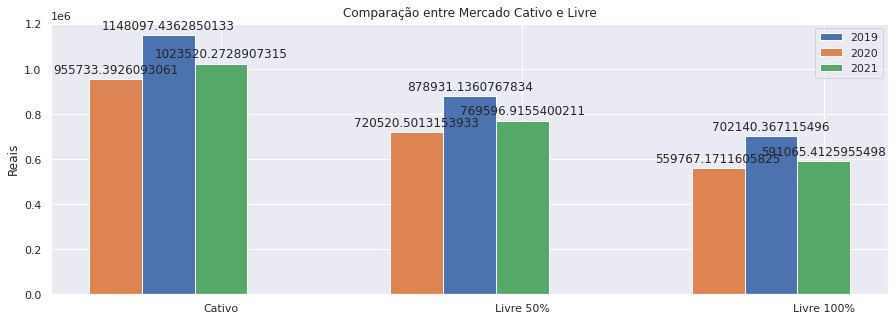

In [ ]:
labels = ['Cativo', 'Livre 50%', 'Livre 100%']
Resultados_2019 = [Cativo_2019, Livre50_2019, Livre100_2019]
Resultados_2020 = [Cativo_2020, Livre50_2020, Livre100_2020]
Resultados_2021 = [Cativo_2021, Livre50_2021, Livre100_2021]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/2, Resultados_2019, width/2, label='2019')
rects2 = ax.bar(x - width, Resultados_2020, width/2, label='2020')
rects3 = ax.bar(x, Resultados_2021, width/2, label='2021')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Reais')
ax.set_title('Comparação entre Mercado Cativo e Livre')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

#figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
#plt.figure(figsize=(40, 20))
#fig.tight_layout()
plt.show()

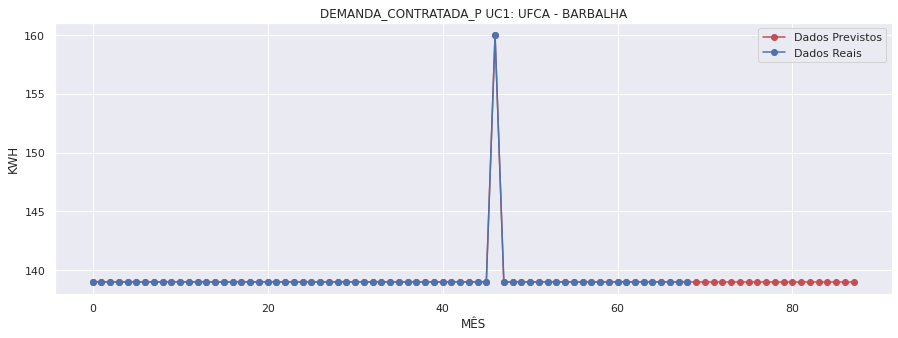

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(modelosUCs[0].dados['DEMANDA_CONTRATADA_P'])), modelosUCs[0].dados['DEMANDA_CONTRATADA_P'], marker='o', color="r")
_ = plt.plot(range(len(dadosUC1['DEMANDA_CONTRATADA_P'])), dadosUC1['DEMANDA_CONTRATADA_P'], marker='o', color="b")
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend([ 'Dados Previstos', 'Dados Reais'])
_ = plt.title("DEMANDA_CONTRATADA_P UC1: UFCA - BARBALHA")
plt.show()

In [ ]:
len(dadosUC1)

69

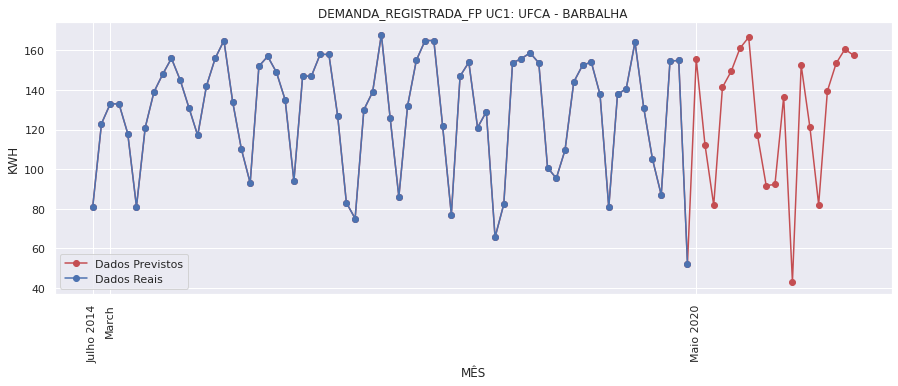

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = plt.plot(range(len(modelosUCs[0].dados['DEMANDA_REGISTRADA_FP'])), modelosUCs[0].dados['DEMANDA_REGISTRADA_FP'], marker='o', color="r")
_ = plt.plot(range(len(dadosUC1['DEMANDA_REGISTRADA_FP'])), dadosUC1['DEMANDA_REGISTRADA_FP'], marker='o', color="b")
_ = plt.xticks([0, len(dadosUC1), 2], [dadosUC1.iloc[0][0]+" "+str(dadosUC1.iloc[0][1]), dadosUC1.iloc[len(dadosUC1)-1][0]+" "+str(dadosUC1.iloc[len(dadosUC1)-1][1]), 'March'],rotation=90)  # Set text labels and properties.
_ = plt.xlabel("MÊS")
_ = plt.ylabel("KWH")
_ = plt.legend([ 'Dados Previstos', 'Dados Reais'])
_ = plt.title("DEMANDA_REGISTRADA_FP UC1: UFCA - BARBALHA")
plt.show()

In [178]:
def etiquetas(dados):
  endDados = len(dados) - 1
  ano = dados.iloc[0][1]
  anoFin = dados.iloc[endDados][1]
  lista_posiciones = []
  lista_etiquetas = []
  while True:
    etiqueta = dados[dados['ANO']==ano].iloc[0][0]+" "+str(dados[dados['ANO']==ano].iloc[0][1])
    lista_posiciones.append(dadosUC1[dadosUC1['ANO']==ano].index[0])
    lista_etiquetas.append(etiqueta)
    ano +=1
    if ano == anoFin:
      break
  lista_posiciones.append(endDados)
  lista_etiquetas.append(dados.iloc[-1][0]+" "+str(dados.iloc[-1][1]))
  return lista_posiciones, lista_etiquetas

In [179]:
def graficar_dado_e_previsao(DadosReais, DadosPrevistos, variavel, UCnome):
  lista_posiciones1, lista_etiquetas1 = etiquetas(DadosReais)
  lista_posiciones2, lista_etiquetas2 = etiquetas(DadosPrevistos.iloc[len(DadosReais)-1:])
  print(lista_posiciones1)
  print(lista_posiciones2)
  lista_posiciones = lista_posiciones1 +lista_posiciones2
  print(lista_posiciones)
  lista_etiquetas = lista_etiquetas1.append(lista_etiquetas2)
  fig, ax = plt.subplots(figsize=(15, 5))
  _ = plt.plot(range(len(DadosPrevistos[variavel])), DadosPrevistos[variavel], marker='o', color="r")
  _ = plt.plot(range(len(DadosReais[variavel])), DadosReais[variavel], marker='o', color="b")
  _ = plt.xticks(lista_posiciones, lista_etiquetas,rotation=90)  # Set text labels and properties.
  _ = plt.xlabel("MÊS")
  _ = plt.ylabel("KWH")
  _ = plt.legend([ 'Dados Previstos', 'Dados Reais'])
  _ = plt.title(variavel+ " da "+UCnome)
  plt.show()
  pass

[0, 4, 16, 28, 40, 52, 68]
[64, 19]
[0, 4, 16, 28, 40, 52, 68, 64, 19]


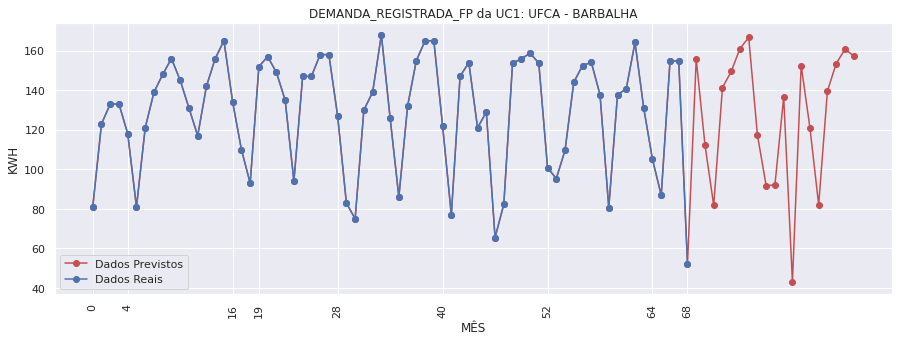

In [180]:
graficar_dado_e_previsao(dadosUC1, modelosUCs[0].dados,'DEMANDA_REGISTRADA_FP', 'UC1: UFCA - BARBALHA')

In [183]:
modelosUCs[0].dados.iloc[-1].index[0]

'MÊS'